In [2]:
import lal
lal.swig_redirect_standard_output_error(False) 

import GWFish.modules as gw

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import h5py
import json
import os
from astropy.cosmology import Planck18
from scipy.fft import fft, fftfreq, ifft
from scipy.optimize import fsolve
import corner

# **Single Event Analysis**

## **Initialize GWFish: networks and waveforms**

1. We need to specify the network: list of detectors that work together (**detectors.yaml** file)
2. Parameters $\vec \theta$ describing the event we want to analyze as a DataFrame
3. Fisher parameters entering in the Fisher matrix
4. The choice of the waveform approximant can be done from all the availbale waveforms from **LALSimulation** in `waveforms.py`(the default waveform class is in frequency domain) and from all the available waveforms in `inspiral_corrections.py`
5. For a more realistic analysis we can include the **duty cycle** of the detectors using `use_duty_cycle = True`

In [4]:
# The detector names can be accessed in detectors.yaml file
# One can list as many detectors as they want: ['LHO', 'LLO', 'VIR', 'CE1', 'CE2', 'ET']
detectors = ['ET']

# The networks are the combinations of detectors that will be used for the analysis
# The detection_SNR is the minimum SNR for a detection:
#   --> The first entry specifies the minimum SNR for a detection in a single detector
#   --> The second entry specifies the minimum network SNR for a detection
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))

use_duty_cycle = True # default is False anyway

################################################################################
# We can choose a waveform approximant class and model from waveforms.py or inspiral_corrections.py:
# gw.inspiral_corrections.IMRPhenomD_PPE
# gw.inspiral_corrections.TaylorF2_PPE
# gw.inspiral_corrections.IMRPhenomD_mult
# gw.inspiral_corrections.TaylorF2_mult
# gw.waveforms.LALFD_Waveform
# gw.waveforms.TaylorF2
# gw.waveforms.IMRPhenomD
################################################

## **Create a single-event injection dictionary: GW150914**

**Injected parameters**

As said before, one can analyze single events or entire populations.

The parameters of a single event need to passed as a **DataFrame** with the following nomenclature:
- `mass_1`: primary mass of the binary in [Msol] (in source frame)
- `mass_2`: secondary mass of the binary in [Msol] (in source frame)
- `redshift`: the redshift of the merger
- `luminosity_distance`:  the luminosity distance of the merger in [Mpc], usually one sets the redshift and calculates the corresponding luminosity distance using Planck18 cosmology
- `theta_jn`: the inclination angle between the line of observation and the perpendicular to the binary plane in [rad]
- `dec`: declination angle in [rad]
- `ra`: right ascension in [rad]
- `psi`: the polarization angle in [rad]
- `phase`: the initial phase of the merger in [rad]
- `geocent_time`: merger time as GPS time in [s]
- `a_1`: dimensionless spin parameter of primary component
- `a_2`: dimensionless spin parameter of secondary component

If the event is a BNS or BHNS (only lambda_1/2):
- `lambda_1`: dimensionless tidal polarizabilty of primary component
- `lambda_2`: dimensionless tidal polarizabilty of secondary component

If we want to consider ppE early-inspiral corrections:
- `beta`: amplitude coefficient of the phase correction
- `PN`: post-Newtonian order

or generalized early-inspiral corrections:
- `delta_phi_i`: amplitude coefficient of the phase correction at i = 2PN order

or multipolar (quadrupolar and octupolar) deviations:
- `k_1`: symmetric quadrupolar deviation
- `k_2`: antisymmetric quadrupolar deviation
- `lambda_1`: symmetric octupolar deviation
- `lambda_2`: antisymmetric octupolar deviation

or tidal deviations:
- `tilde`: deviation at 5PN
- `delta_tilde`: deviation at 6PN

We can also define:
- `tilt_1`: zenith angle between the spin and orbital angular momenta for the primary component in [rad]
- `tilt_2`: zenith angle between the spin and orbital angular momenta for the secondary component in [rad]
- `phi_12`: difference between total and orbital angular momentum azimuthal angles in [rad]
- `phi_jl`: difference between the azimuthal angles of the individual spin vector projections on to the orbital plane in [rad]

In [12]:
# Download the file from: https://gwosc.org/eventapi/html/GWTC-1-confident/GW150914/v3/
# Upload it on your local directory 
bin_file = 'GW150914_GWTC-1.hdf5'

with h5py.File(bin_file, 'r') as file:
    # Print the dataset names in .hdf5 file
    print("Dataset names:", list(file.keys()))

Dataset names: ['IMRPhenomPv2_posterior', 'Overall_posterior', 'SEOBNRv3_posterior', 'prior']


In [13]:
#Choose the dataset
with h5py.File(bin_file, 'r') as file:
    bin_data = file['Overall_posterior'][:]

In [14]:
#Show the posterior samples data
data=pd.DataFrame(bin_data)
data

,costheta_jn,luminosity_distance_Mpc,right_ascension,declination,m1_detector_frame_Msun,m2_detector_frame_Msun,spin1,spin2,costilt1,costilt2
0,-0.976633,517.176717,1.456176,-1.257815,39.037380,37.044563,0.417147,0.867740,-0.280624,0.403853
1,-0.700404,401.626864,2.658802,-0.874661,34.620096,34.184416,0.125709,0.260679,-0.757349,-0.312285
2,-0.840752,369.579071,1.106548,-1.136396,37.894343,33.970520,0.581047,0.926893,0.649781,-0.510843
3,-0.583657,386.935268,2.077180,-1.246351,36.412973,35.684463,0.235808,0.094391,0.116578,-0.720505
4,-0.928271,345.104345,0.993604,-1.069243,39.477251,31.645008,0.511521,0.868009,-0.438237,0.269333
...,...,...,...,...,...,...,...,...,...,...
8345,-0.691637,306.985025,1.485646,-1.269228,37.561962,33.355792,0.484003,0.627191,0.194507,-0.408345
8346,-0.834615,462.649414,2.065362,-1.265618,37.824298,36.674075,0.589654,0.650758,-0.737792,0.875384
8347,-0.911463,448.930876,1.536913,-1.257956,38.063291,35.757913,0.708407,0.714805,0.852085,-0.797475
8348,-0.856914,561.020036,2.367289,-1.211824,44.884396,31.592433,0.389284,0.521304,-0.251461,0.830526


In [15]:
#Take the median or the mean of the posterior samples
mean_values = data.mean()
median_values = data.median()

parameters = pd.DataFrame(median_values)
parameters2 = pd.DataFrame(mean_values)

parameters, parameters2

(                                  0
 costheta_jn               -0.893325
 luminosity_distance_Mpc  439.298905
 right_ascension            1.676874
 declination               -1.214806
 m1_detector_frame_Msun    38.918565
 m2_detector_frame_Msun    33.458614
 spin1                      0.272104
 spin2                      0.333559
 costilt1                   0.031810
 costilt2                  -0.129647,
                                   0
 costheta_jn               -0.799226
 luminosity_distance_Mpc  436.498843
 right_ascension            1.706770
 declination               -1.179399
 m1_detector_frame_Msun    39.218637
 m2_detector_frame_Msun    33.102043
 spin1                      0.325860
 spin2                      0.371814
 costilt1                   0.026141
 costilt2                  -0.093227)

In [16]:
#Parameters dictionary from /content/GW150914_GWTC-1.hdf5
z = np.array([0.088])
parameters = {
    'mass_1': np.array([35.77074]) * (1 + z),  #38.918565 in detector frame
    'mass_2': np.array([30.75240]) * (1 + z),  #33.458614 in detector frame
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,

    'a_1':np.array([0.272104]),
    'a_2':np.array([0.333559]),

    'theta_jn': np.array([np.radians(153.2940853)]),
    'ra': np.array([1.676874]),
    'dec': np.array([-1.214806]),

    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4])
}
parameters = pd.DataFrame(parameters)

### **Some computations on GW150914: SNR, $\delta \theta_i$ and $\Delta\Omega_{90\%}$**

#### **Injected parameters $\vec \theta$ and fisher parameters: GW150914**

In [17]:
#Parameters dictionary from arXiv:1603.08955
z = np.array([0.088])
parameters = {
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,
    'mass_1': np.array([35.7]),
    'mass_2': np.array([29.1]),
    'a_1':np.array([0.32]),
    'a_2':np.array([0.34]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4])
}
parameters = pd.DataFrame(parameters)

#Fisher parameters dictionary
fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance','theta_jn',
                     'dec','ra',
                     'psi','phase', 'geocent_time'    
                    ]
parameters

,redshift,luminosity_distance,mass_1,mass_2,a_1,a_2,theta_jn,ra,dec,psi,phase,geocent_time
0,0.088,415.380325,35.7,29.1,0.32,0.34,2.420772,1.7,-1.2,0.0,0.0,1.126259e+09


In [20]:
# Example: ET network and IMRPhenomD template 
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True,

waveform_class = gw.waveforms.LALFD_Waveform
waveform_model = 'IMRPhenomD'

detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network = network,
        parameter_values = parameters,
        fisher_parameters = fisher_parameters,
        waveform_model = waveform_model,
        waveform_class = waveform_class,
        )
print('\nThe network SNR of the event is ', network_snr)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


The network SNR of the event is  [942.20821789]


In [21]:
# One can create a dictionary using the parameter errors with the same fisher parameters order 
parameter_errors_dict = {}
for i, parameter in enumerate(fisher_parameters):
    parameter_errors_dict['err_' + parameter] = np.squeeze(parameter_errors)[i]
    
# Choose a specific waveform paramater
parameter_of_interest = 'mass_1'
print(parameter_errors_dict['err_' + parameter_of_interest])

0.5870549157528324


In [22]:
#If dec and ra are in the Fisher parameters dictionary:
print('The sky localization of the event is ', sky_localization, 'rad^2')
percentile = 90.
sky_localization_90cl = sky_localization * gw.fishermatrix.sky_localization_percentile_factor(percentile)
print('The sky localization at 90 % of the event is ', sky_localization_90cl,  'deg^2')

The sky localization of the event is  [1.10505487] rad^2
The sky localization at 90 % of the event is  [16706.08906892] deg^2


#### **Signal-to-noise-ratio dependencies: SNR vs $\theta_{i}$**

In [26]:
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

z = np.array([0.088])
parameters = {
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,
    'mass_1': np.array([35.7]) * (1 + z),
    'mass_2': np.array([29.1]) * (1 + z),
    'a_1':np.array([0.32]),
    'a_2':np.array([0.34]),
    #'theta_jn': np.array([2.68]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4])
}
parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance', 
                     #'theta_jn',
                     'dec','ra',
                     'psi','phase', 'geocent_time'
                    ]

waveform_class = gw.waveforms.LALFD_Waveform
waveform_model = 'IMRPhenomD'

# Choose a specific waveform parameter
parameter_of_interest = 'theta_jn'

with open('SNR_vs_' + parameter_of_interest + '.txt', 'w') as f:
    for theta in np.arange(0,3.5,0.1):
        parameters[parameter_of_interest] = theta

        detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
            network=network,
            parameter_values=parameters,
            fisher_parameters=fisher_parameters,
            waveform_model = waveform_model,
            waveform_class = waveform_class
        )
        network_snr_str = [str(snr) for snr in network_snr]
        f.write(" ".join(network_snr_str) + " " + str(theta) + "\n")

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.31it/s]


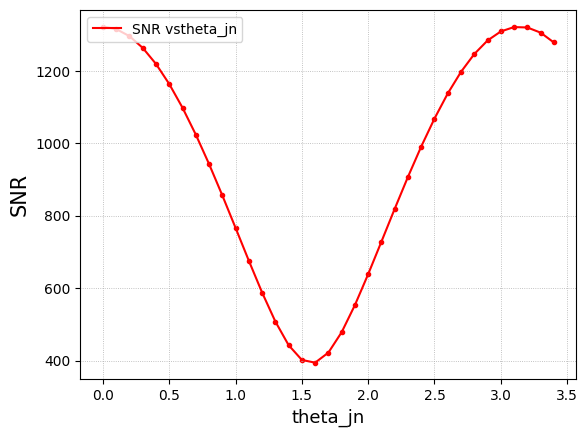

In [27]:
# We can plot the results

data = np.loadtxt('SNR_vs_' + parameter_of_interest + '.txt')
x = data[:, 1]
y = data[:, 0]

fig, ax = plt.subplots()
ax.plot(x, y, color = 'red', linestyle='-', label = r'SNR vs' + parameter_of_interest)
ax.scatter(x, y, color='red', marker='.')
ax.set_xlabel(parameter_of_interest, fontsize=13)
ax.set_ylabel('SNR', fontsize=15)
ax.legend(loc='upper left', fontsize=10, ncol=1, fancybox=True)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')

plt.show()

## **PSDs: plots and projected signals**

### **Comparison between different detector-networks**

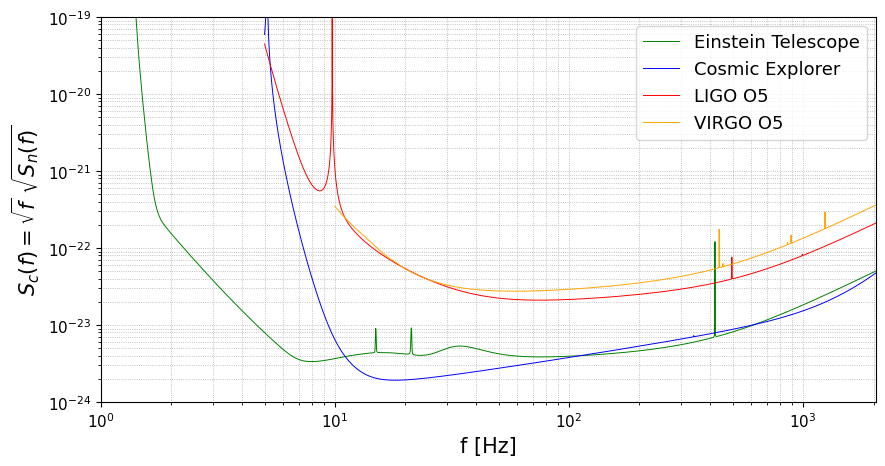

In [28]:
# The PSD of the detector is stored in the detector_psd folder
# We need to specify the path to the file
GWFish_path = 'GWFish/'
psd_et = np.loadtxt(os.path.join(GWFish_path,'detector_psd/ET_psd.txt'), usecols=[0,1])
psd_ce = np.loadtxt(os.path.join(GWFish_path,'detector_psd/CE1_psd.txt'), usecols=[0,1])
psd_llo = np.loadtxt(os.path.join(GWFish_path,'detector_psd/LIGO_O5_psd.txt'), usecols=[0,1])
psd_vo = np.loadtxt(os.path.join(GWFish_path,'detector_psd/Virgo_O5_psd.txt'), usecols=[0,1])

detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True # default is False anyway

# and the bandwith of the detector
frequencyvector = network.detectors[0].frequencyvector[:, 0]
################################################################################

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(psd_et[:,0], np.sqrt(psd_et[:,0]) * np.sqrt(psd_et[:,1]), linewidth = 0.7, color = 'green', label = 'Einstein Telescope')
ax.plot(psd_ce[:,0], np.sqrt(psd_ce[:,0]) * np.sqrt(psd_ce[:,1]), linewidth = 0.7, color = 'blue', label = 'Cosmic Explorer')
ax.plot(psd_llo[:,0], np.sqrt(psd_llo[:,0]) * np.sqrt(psd_llo[:,1]), linewidth = 0.7, color = 'red', label = 'LIGO O5')
ax.plot(psd_vo[:,0], np.sqrt(psd_vo[:,0]) * np.sqrt(psd_vo[:,1]), linewidth = 0.7, color = 'orange', label = 'VIRGO O5')

ax.set_xlim(1.,frequencyvector[-1])
ax.set_ylim(1e-24, 1e-19)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('f [Hz]', fontsize=15)
ax.set_ylabel('$S_c(f)=\sqrt{f}$ $\sqrt{S_n(f)}$ ', fontsize=15)
ax.tick_params(axis='x', which='major', labelsize=11)
ax.tick_params(axis='y', which='major', labelsize=11)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.legend(loc='upper right', fontsize=13, ncol=1, fancybox=True)
#plt.savefig('asd_comparison.pdf')
plt.show()

### **How to create a new `_psd.txt` file and plot the $S_n(f)$**

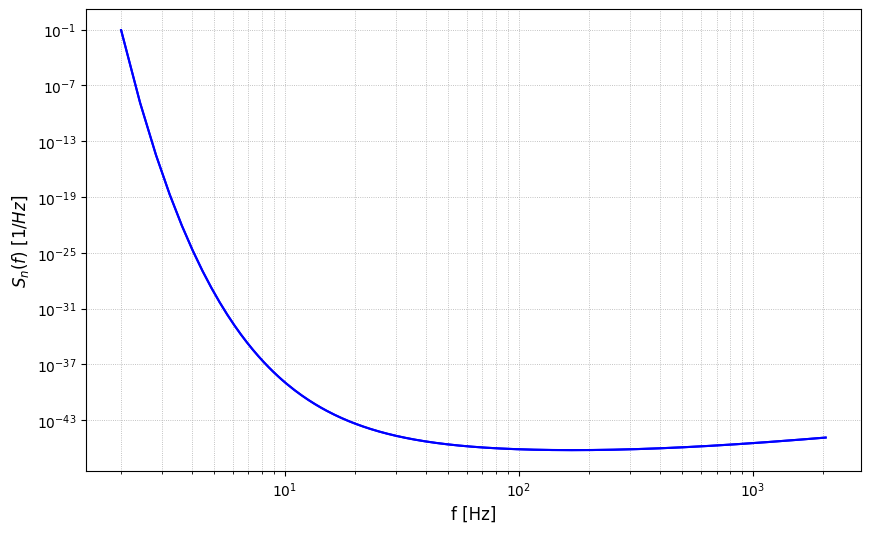

In [30]:
# LHO_O1 and LLO_O1 fit from arXiv:1603.08955

S0 = 0.8464
a0 = 47.8466
a1 = -92.1896
a2 = 35.9273
a3 = -7.61447
a4 = 0.916742
a5 = -0.0588089
a6 = 0.00156345

def S(frequency):
    # Esempio di definizione di una funzione S
    return S0*np.exp(2*(a0+a1*(np.log(frequency))+ \
                          a2*((np.log(frequency))**2)+ \
                          a3*((np.log(frequency))**3)+ \
                          a4*((np.log(frequency))**4)+ \
                          a5*((np.log(frequency))**5)+ \
                          a6*((np.log(frequency))**6)))
    
# Frequency bandwith (same of ET)
start_freq = 2  # fmin
end_freq = 2048  # fmax
num_points = 5000
step_size = (end_freq - start_freq) / (num_points - 1)

# Generate the discrete frequencies
frequencies = np.linspace(start_freq, end_freq, num_points)

# Compute S(f)
S_values = S(frequencies)

# Plot S_n(f)
plt.figure(figsize=(10, 6))

plt.plot(frequencies, S_values, color='blue')

plt.loglog(frequencies, S_values, color='blue')
plt.xlabel('f [Hz]',fontsize = 12)
plt.ylabel('$S_n(f)$ $[1/Hz]$',fontsize = 12)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')

plt.show()

# Create the _psd.txt file
with open('LIGO_O1_fit_psd.txt', 'w') as file:
    for freq, S_val in zip(frequencies, S_values):
        file.write(f"{freq} {S_val}\n")

### **How to plot the projected characteristic strain $h_c(f)$...**

The characteristic strain is a particular combination of signal/ASD with frequency so that the output is adimensional and the area in between the signal and the detector's densitivity curve can be interpreted as SNR:

$$
SNR^2 = 4\int\frac{h(f)h^*(f)}{S_n}df
$$

Therefore:

$$
h_c = 2f|h| \quad \text{and} \quad S_c = \sqrt{f}\sqrt{S_n}
$$

In [22]:
def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value
    
dL = 400.
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]
tc = 1126259462.4

parameters = {
    'luminosity_distance': np.array([dL]),
    'a_1': np.array([0.9]),
    'a_2': np.array([0.8]),
    'theta_jn': np.array([np.radians(60.)]),
    'ra': np.array([4.]),
    'dec': np.array([-0.5]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),
    'cut' :np.array([1.])
}
parameters = pd.DataFrame(parameters)

# Mass inputs
mass_ratio = 3.
mass_tot = 70.
mass_2 = mass_tot/(1 + mass_ratio)
mass_1 = mass_2*mass_ratio
parameters['mass_1'] = mass_1 * (1 + z)
parameters['mass_2'] = mass_2 * (1 + z)

#### **...PSDs comparison**

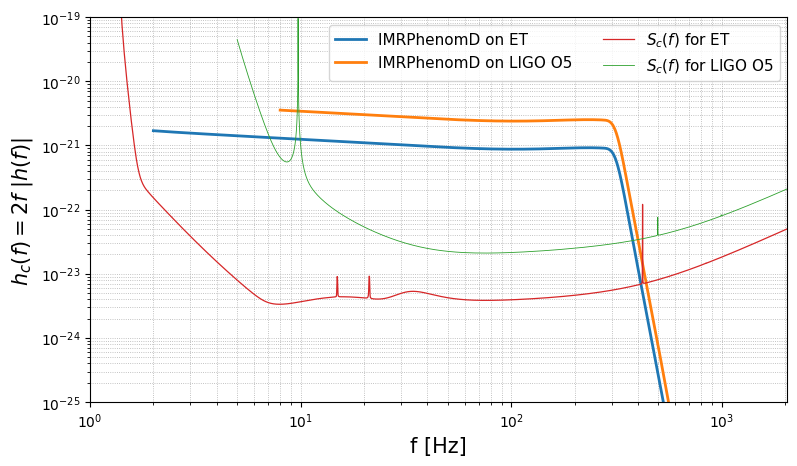

In [20]:
waveform_class = gw.waveforms.IMRPhenomD
waveform_model = 'IMRPhenomD'
################################################################################
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
data_params = {
    'frequencyvector': network.detectors[0].frequencyvector,
    'f_ref': 50.
}
waveform_obj = waveform_class(waveform_model, parameters.iloc[0], data_params)
wave = waveform_obj()
t_of_f = waveform_obj.t_of_f

signal = gw.detection.projection(parameters.iloc[0], network.detectors[0], wave, t_of_f)
################################################################################
# The projected amplitude is stored in the signal variable
# We have 3 columns as ET is made of 3 detectors
################################################################################
signal0 = signal[:, 0]
signal1 = signal[:, 1]
signal2 = signal[:, 2]

signal_ampl = np.sqrt(np.abs(signal0)**2. + np.abs(signal1)**2. + np.abs(signal2)**2.)
################################################################################
# Otherwise, with LIGO:
detectors_2 = ['LLO', 'LHO']
network_2 = gw.detection.Network(detector_ids = detectors_2, detection_SNR = (0., 8.))
data_params_2 = {
    'frequencyvector': network_2.detectors[0].frequencyvector,
    'f_ref': 50.
}
################################################################################

waveform_obj_2 = waveform_class(waveform_model, parameters.iloc[0], data_params_2)
wave_2 = waveform_obj_2()
t_of_f_2 = waveform_obj_2.t_of_f

signal_LLO = gw.detection.projection(parameters.iloc[0], network_2.detectors[0], wave_2, t_of_f_2)
signal_LHO = gw.detection.projection(parameters.iloc[0], network_2.detectors[1], wave_2, t_of_f_2)

signal0_2 = signal_LLO[:, 0]
signal1_2 = signal_LHO[:, 0]

signal_ampl_2 = np.sqrt(np.abs(signal0_2)**2. + np.abs(signal0_2)**2.)
###############################################################################
frequencyvector = network.detectors[0].frequencyvector[:, 0]
frequencyvector_2 = network_2.detectors[0].frequencyvector[:, 0]
###############################################################################
# The PSD of the detector is stored in the detector_psd folder
# We need to specify the path to the file

GWFish_path = 'GWFish/' # path on Colab (check for right path on your PC!)
psd_et = np.loadtxt(os.path.join(GWFish_path,'detector_psd/ET_psd.txt'), usecols=[0,1])
psd_llo = np.loadtxt(os.path.join(GWFish_path,'detector_psd/LIGO_O5_psd.txt'), usecols=[0,1])
################################################################################

fig, ax = plt.subplots(figsize=(9,5))

ax.plot(frequencyvector, 2. * frequencyvector * signal_ampl, linewidth=2, label='IMRPhenomD on ET')
ax.plot(frequencyvector_2, 2. * frequencyvector_2 * signal_ampl_2, linewidth=2, label='IMRPhenomD on LIGO O5')
ax.plot(psd_et[:,0], np.sqrt(psd_et[:,0]) * np.sqrt(psd_et[:,1]), linewidth = 0.9, color = 'C3', label = '$S_c(f)$ for ET')
ax.plot(psd_llo[:,0], np.sqrt(psd_llo[:,0]) * np.sqrt(psd_llo[:,1]), linewidth = 0.6, color = 'C2', label = '$S_c(f)$ for LIGO O5')

ax.set_xlim(1., frequencyvector[-1])
ax.set_ylim(1e-25, 1e-19)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('f [Hz]', fontsize=15)
ax.set_ylabel('$h_c(f)=2f$ $|h(f)|$ ', fontsize=15)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.legend(loc='upper right', fontsize=11, ncol=2, fancybox=True)
#plt.savefig('network_projection_comparison.pdf')
plt.show()

#### **...template comparison**

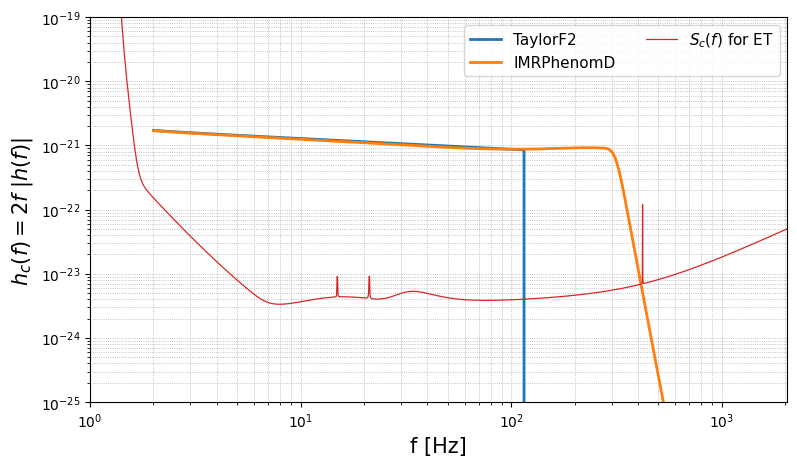

In [21]:
waveform_class = gw.waveforms.TaylorF2
waveform_model = 'TaylorF2'
waveform_class_2 = gw.waveforms.IMRPhenomD
waveform_model_2 = 'IMRPhenomD'
################################################################################
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
data_params = {
    'frequencyvector': network.detectors[0].frequencyvector,
    'f_ref': 50.
}

waveform_obj = waveform_class(waveform_model, parameters.iloc[0], data_params)
wave = waveform_obj()
t_of_f = waveform_obj.t_of_f

signal = gw.detection.projection(parameters.iloc[0], network.detectors[0], wave, t_of_f)
################################################################################
signal1 = signal[:, 0]
signal2 = signal[:, 1]
signal3 = signal[:, 2]

signal_ampl = np.sqrt(np.abs(signal1)**2. + np.abs(signal2)**2. + np.abs(signal3)**2.)
################################################################################
waveform_obj_2 = waveform_class_2(waveform_model_2, parameters.iloc[0], data_params)
wave_2 = waveform_obj_2()
t_of_f_2 = waveform_obj_2.t_of_f

signal_2 = gw.detection.projection(parameters.iloc[0], network.detectors[0], wave_2, t_of_f_2)

signal1_2 = signal_2[:, 0]
signal2_2 = signal_2[:, 1]
signal3_2 = signal_2[:, 2]

signal_ampl_2 = np.sqrt(np.abs(signal1_2)**2. + np.abs(signal2_2)**2. + np.abs(signal3_2)**2.)
################################################################################
frequencyvector = network.detectors[0].frequencyvector[:, 0]
###############################################################################
GWFish_path = 'GWFish/' # path on Colab (check for right path on your PC!)
psd_et = np.loadtxt(os.path.join(GWFish_path,'detector_psd/ET_psd.txt'), usecols=[0,1])
################################################################################

fig, ax = plt.subplots(figsize=(9,5))

ax.plot(frequencyvector, 2. * frequencyvector * signal_ampl, linewidth=2, label='TaylorF2')
ax.plot(frequencyvector, 2. * frequencyvector * signal_ampl_2, linewidth=2, label='IMRPhenomD')
ax.plot(psd_et[:,0], np.sqrt(psd_et[:,0]) * np.sqrt(psd_et[:,1]), linewidth = 0.9, color = 'C3', label = '$S_c(f)$ for ET')

ax.set_xlim(1., frequencyvector[-1])
ax.set_ylim(1e-25, 1e-19)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('f [Hz]', fontsize=15)
ax.set_ylabel('$h_c(f)=2f$ $|h(f)|$ ', fontsize=15)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.legend(loc='upper right', fontsize=11, ncol=2, fancybox=True)
#plt.savefig('network_projection_comparison.pdf')
plt.show()

## **Figures: amplitudes $h_{+/\times}(f)$, phase $\Phi(f)$, merging time $t_c(f)$**

In [3]:
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

data_params = {
    'frequencyvector': network.detectors[0].frequencyvector,
    'f_ref': 50.
}

z = np.array([0.088])
parameters = {
    'mass_1': np.array([35.77074]) * (1 + z),  #38.918565 in detector frame
    'mass_2': np.array([30.75240]) * (1 + z),  #33.458614 in detector frame
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,
    'a_1':np.array([0.32]),
    'a_2':np.array([0.34]),
    'theta_jn': np.array([np.radians(153.2940853)]),
    'ra': np.array([1.676874]),
    'dec': np.array([-1.214806]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    #'geocent_time': np.array([1126259462.4])
}
parameters = pd.DataFrame(parameters)

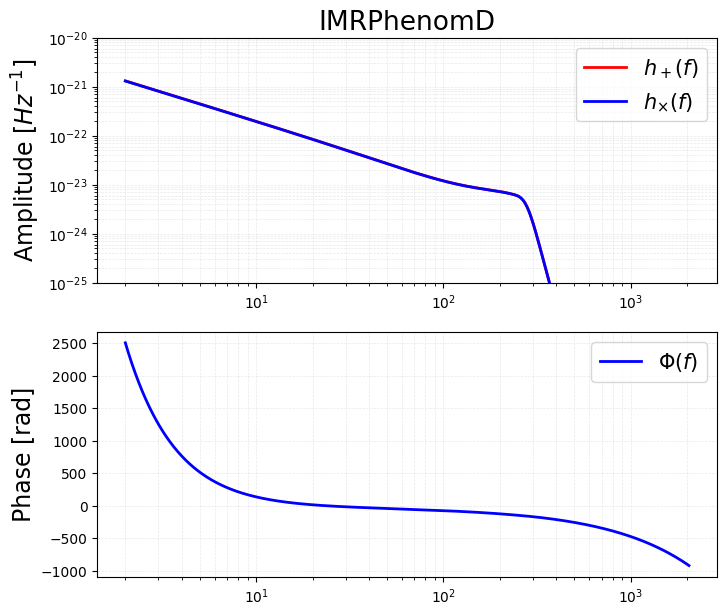

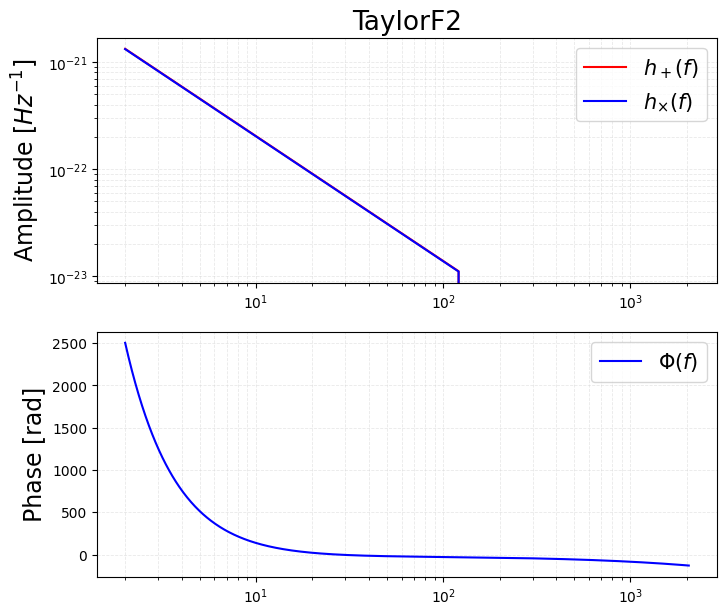

In [4]:
waveform_model = 'IMRPhenomD'
waveform = gw.waveforms.IMRPhenomD(waveform_model, parameters.iloc[0], data_params)

waveform_model_2 = 'TaylorF2'
waveform_2 = gw.waveforms.TaylorF2(waveform_model_2, parameters.iloc[0], data_params)

waveform.plot(output_folder='./')
waveform_2.plot(output_folder='./')

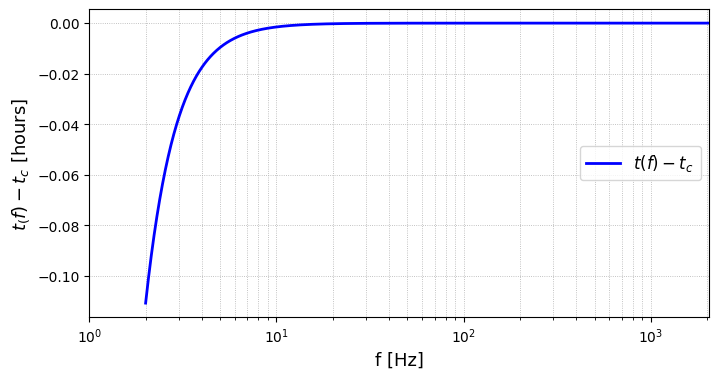

In [23]:
waveform_model = 'IMRPhenomD'
waveform = gw.waveforms.IMRPhenomD(waveform_model, parameters.iloc[0], data_params)
frequencyvector = network.detectors[0].frequencyvector[:, 0]
t_of_f = waveform.t_of_f

conv_to_hours = 3600
# Plot the time before merger as a function of frequency
fig, ax = plt.subplots(figsize = (8,4))

ax.plot(frequencyvector, (t_of_f - parameters['geocent_time'].iloc[0]) / conv_to_hours, linewidth = 2., color = 'blue' , label = '$t(f) - t_c$ ')

ax.set_xlim(1.,frequencyvector[-1])
ax.set_xscale('log')
ax.set_xlabel('f [Hz]', fontsize = 13)
ax.set_ylabel('$t_(f) - t_c$ [hours]', fontsize=13)
ax.legend(loc='center right', fontsize=12, ncol=1, fancybox=True)
plt.grid(linestyle = 'dotted', linewidth = '0.6', which = 'both')

#plt.savefig('t_of_f.pdf')
plt.show()

## **Save results to file and plot the combined posterior distributions**

The difference with respect to the ```compute_network_errors``` function is that one can pass different network combinations and get results files for each of them. This means that if your detectors list is something like ```['LHO', 'VIR', 'ET']``` and you want to create 2 different networks out of it, i.e ```['LHO', 'VIR']```, and ```['ET']``` alone, then one should inizialize the ```analyze_and_save_to_txt``` function as follows:

```
network = gw.detection.Network(detector_ids = ['LHO', 'VIR', 'ET'], detection_SNR = (0., 8.))
```

and then specify the different network combinations:

```
sub_network_ids_list = [[0, 1, 2], [1, 2], [3]]
```

In [9]:
# Save the results onto a specific local directory
!mkdir gwfish_results

In [24]:
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True 

z = 0.088
tc = 1126259462.4

parameters = {
    'a_1': np.array([0.32]),
    'a_2': np.array([0.34]),
    'luminosity_distance': Planck18.luminosity_distance(z).value,
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),
}
parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase','psi','geocent_time',
                     'ra','dec',
                     'luminosity_distance','theta_jn',
                     ]

waveform_class = gw.waveforms.IMRPhenomD
waveform_model = 'IMRPhenomD'

mass_ratio = 1.2
mass_tot = 50.
mass_2 = mass_tot/(1 + mass_ratio)
mass_1 = mass_2*mass_ratio
parameters['mass_1'] = mass_1 * (1 + z)
parameters['mass_2'] = mass_2 * (1 + z)

data_folder = 'gwfish_results'
gw.fishermatrix.analyze_and_save_to_txt(network = network,
                                        parameter_values  = parameters,
                                        fisher_parameters = fisher_parameters,
                                        sub_network_ids_list = [[0]],
                                        population_name = 'Single_event',
                                        waveform_class = waveform_class,
                                        waveform_model = waveform_model,
                                        save_path = data_folder,
                                        save_matrices = True)

100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.95s/it]


In [15]:
fisher_matrix = np.load(data_folder + '/' + 'fisher_matrices_ET_Single_event_SNR8.npy')
errors = pd.read_csv(data_folder + '/' + 'Errors_ET_Single_event_SNR8.txt', delimiter = ' ')

# One can access all the column names of the errors output file:
errors.keys()
errors

,network_SNR,a_1,a_2,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,...,err_a_1,err_a_2,err_phase,err_psi,err_geocent_time,err_ra,err_dec,err_luminosity_distance,err_theta_jn,err_sky_location
0,819.605135,0.32,0.34,415.4,2.421,1.7,-1.2,0.0,0.0,1.126000e+09,...,0.03645,0.04667,7.741,3.109,0.01082,1.48,0.4916,1333.0,3.24,0.8082


In [18]:
# If you want to clean your results
import shutil
folder_path = 'gwfish_results'
shutil.rmtree(folder_path, ignore_errors=True)

### **Corner plot**

/tmp/ipykernel_2518/400743733.py:42: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))


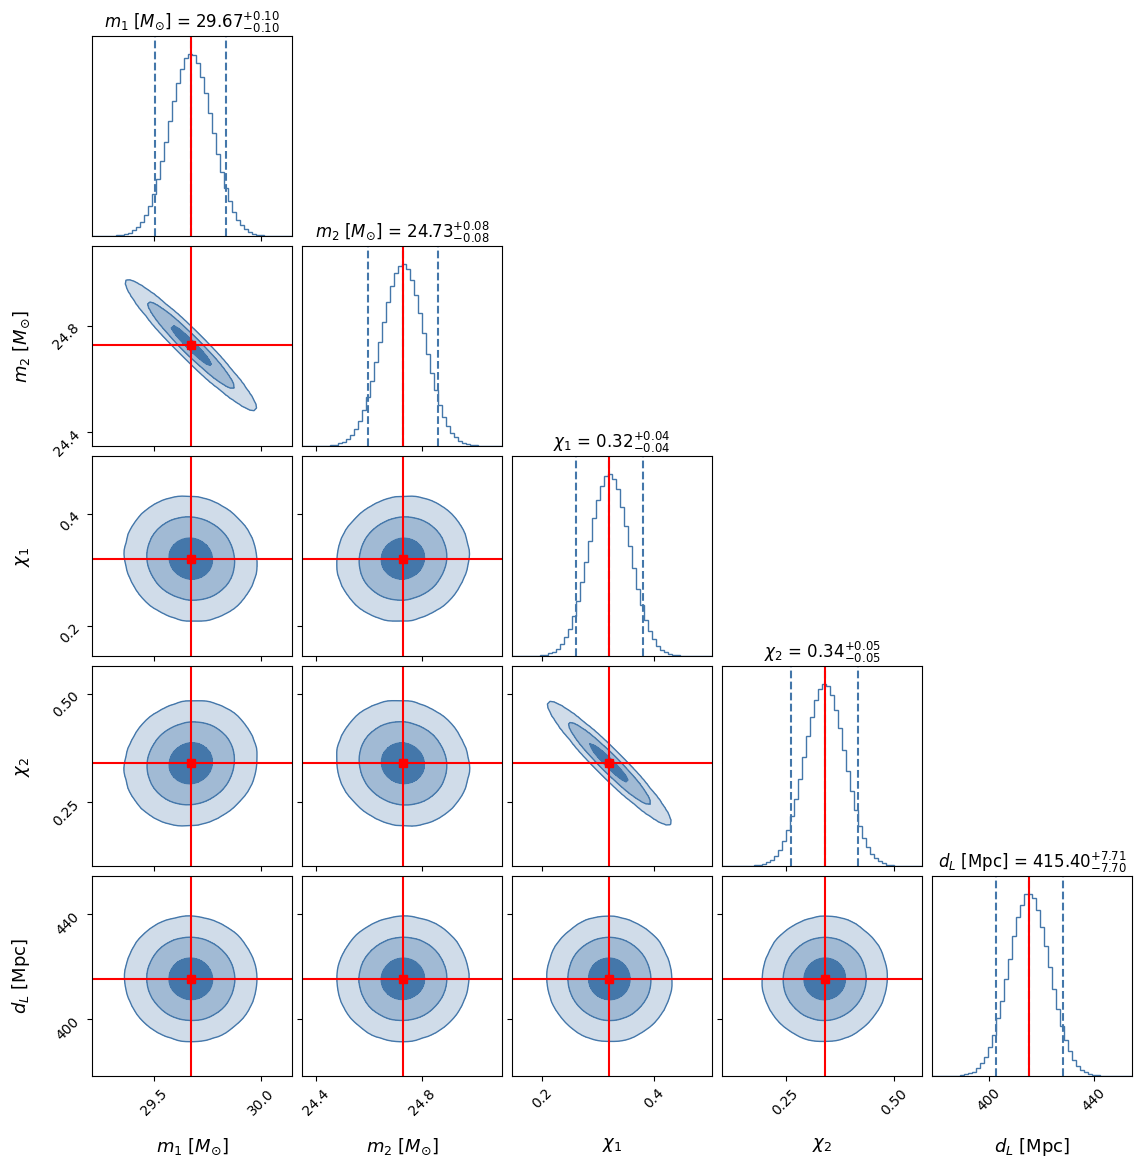

In [26]:
CORNER_KWARGS = dict(
    color = "#4477AA", #Blue
    #color="#228833", #Green
    #color="#EE6677", #Red 
    #truth_color='black',
    truth_color='red',
    bins = 50,
    smooth = 1.1,
    plot_datapoints = False,
    label_kwargs = dict(fontsize = 13),
    show_titles = True,
    title_kwargs = dict(fontsize = 12),
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours = True,
    max_n_ticks = 2,
    title_fmt=".2f",
    contour_kwargs={'linewidths':1},
    hist_kwargs = {'linewidth':1},
    quantiles=(0.05,0.5,0.95)
    )

corner_lbs = ['$m_1$ $[M_{\odot}]$', '$m_2$ $[M_{\odot}]$',
              r'$\chi_1$', r'$\chi_2$',
              '$d_L$ [Mpc]', r'$\theta_{jn}$ [rad]',
              '$ra$', '$dec$',
              '$\phi_c$ [rad]','$t_c$ [GPS]', '$\Psi$'
              ]

mean_lbs = ['mass_1', 'mass_2',
            'a_1', 'a_2',
            'luminosity_distance', 'theta_jn',
            'ra', 'dec',
            'phase','geocent_time', 'psi'
            ]

mean_values = parameters[mean_lbs].iloc[0]
cov_matrix = np.load(data_folder + '/' + 'inv_fisher_matrices_ET_Single_event_SNR8.npy')[0, :, :]

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))

# Marginalization
selected_indices = [0, 1, 2, 3, 4]
selected_samples = samples[:, selected_indices]
selected_labels = [corner_lbs[i] for i in selected_indices]
selected_mean_values = mean_values[selected_indices]

fig = corner.corner(selected_samples, labels=selected_labels, truths=selected_mean_values, **CORNER_KWARGS)

#plt.savefig('corner.pdf')
plt.show()

## **ppE early inspiral deviations**

In [32]:
################################################################################
################################################################################
#Parameters dictionary from Properties of the Binary Black Hole Merger GW150914 (B. P. Abbott et al.)
#change in M1, M2, DL, a1, a2

z = 0.088

parameters = {
    'mass_1': np.array([35.7]) * (1 + z),  #detector frame
    'mass_2': np.array([29.1]) * (1 + z),  #detector frame
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,

    'a_1':np.array([0.]),
    'a_2':np.array([0.]),

    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),

    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),

    'cut': np.array([1.]), #for TayloF2_ppE

    'beta':np.array([0.])
}
parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance',
                     'phase',
                     'geocent_time'
                     #'theta_jn'
                     #'dec','ra',
                     #'psi',
                     ,'beta'
                    ]

parameter_of_interest = 'beta'
PN_min = -1.
PN_max = 4.

### SNR-luminosity distance test

One would expect that the Fisher matrix entry corresponding to dL-dL should be approximated by the ratio between the SNR and the luminosity distance squared as follows:

$$
\frac{1}{SNR} = \frac{\Delta d_L}{d_L}
$$

where $\Delta d_L = \sqrt{\left[F\right]^{-1}_{d_L,d_L}}$, with $F$ the Fisher matrix.

This can be derived from the fact that $\partial_{d_L}h = -\frac{1}{d_L}h$ and
$$\frac{1}{\left(\Delta d_L\right)^2} \sim F_{d_L,d_L}=\langle \partial_{d_L}h|\partial_{d_L}h\rangle \sim \frac{SNR^2}{d_L^2}$$

where the inverse of the error on distance is the corresponding entry of the Fisher matrix $F_{d_L,d_L}$ (assuming correlations are negligible).

A rough approximation in literature takes: $\frac{\Delta d_L}{d_L} \sim \frac{2}{SNR}$.

In [30]:
detectors = ['LLO_O1','LHO_O1']

network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_model = 'IMRPhenomD_PPE'
waveform_class = gw.inspiral_corrections.IMRPhenomD_PPE

waveform_model_2 = 'TaylorF2_PPE'
waveform_class_2 = gw.inspiral_corrections.TaylorF2_PPE
###################################################################################
TaylorF2_results=[]
# The test has to be valid for any deviations entering any PN orders
for PN in np.arange(PN_min, PN_max, 0.5):

    parameters['PN'] = PN

    data_folder = 'Gwfish_results_TF2'
    gw.fishermatrix.analyze_and_save_to_txt(network=network,
                                            parameter_values=parameters,
                                            fisher_parameters=fisher_parameters,
                                            sub_network_ids_list=[[0,1]],
                                            population_name='GW150914',
                                            waveform_class=waveform_class_2,
                                            waveform_model=waveform_model_2,
                                            save_path=data_folder,
                                            save_matrices=True)

    fisher_matrix = np.load(data_folder + '/' + 'fisher_matrices_LLO_O1_LHO_O1_GW150914_SNR8.npy')
    my_fisher = fisher_matrix[0, :, :]
    errors = pd.read_csv(data_folder + '/' + 'Errors_LLO_O1_LHO_O1_GW150914_SNR8.txt', delimiter=' ')

    snr_times_delta_dL = errors['network_SNR'].iloc[0] / ((my_fisher[4, 4]**(0.5))*errors['luminosity_distance'].iloc[0])

    TaylorF2_results.append((PN, snr_times_delta_dL))

# GWFish results
with open('SNR_test_TF2.txt', 'w') as f:
    for result in TaylorF2_results:
        f.write(f'{result[0]} {result[1]}\n')
################################################################################
IMRPhenomD_results=[]

for PN in np.arange(PN_min, PN_max, 0.5):

    parameters['PN'] = PN

    data_folder = 'Gwfish_results_IMRD'
    gw.fishermatrix.analyze_and_save_to_txt(network=network,
                                            parameter_values=parameters,
                                            fisher_parameters=fisher_parameters,
                                            sub_network_ids_list=[[0,1]],
                                            population_name='GW150914',
                                            waveform_class=waveform_class,
                                            waveform_model=waveform_model,
                                            save_path=data_folder,
                                            save_matrices=True)

    fisher_matrix = np.load(data_folder + '/' + 'fisher_matrices_LLO_O1_LHO_O1_GW150914_SNR8.npy')
    my_fisher = fisher_matrix[0, :, :]
    errors = pd.read_csv(data_folder + '/' + 'Errors_LLO_O1_LHO_O1_GW150914_SNR8.txt', delimiter=' ')

    snr_times_delta_dL = errors['network_SNR'].iloc[0] / ((my_fisher[4, 4]**(0.5))*errors['luminosity_distance'].iloc[0])

    IMRPhenomD_results.append((PN, snr_times_delta_dL))

# GWFish results
with open('SNR_test_IMRD.txt', 'w') as f:
    for result in IMRPhenomD_results:
        f.write(f'{result[0]} {result[1]}\n')

100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.69s/it]


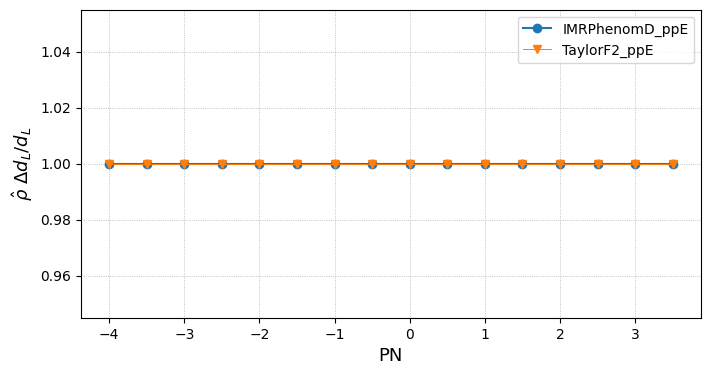

In [33]:
TaylorF2_results = np.loadtxt('SNR_test_TF2.txt')
IMRPhenomD_results = np.loadtxt('SNR_test_IMRD.txt')

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(IMRPhenomD_results[:,0], IMRPhenomD_results[:,1], marker='o', label='IMRPhenomD_ppE')
ax.plot(TaylorF2_results[:,0], TaylorF2_results[:,1], marker='v', linewidth=0.7, label='TaylorF2_ppE')

ax.set_xlabel('PN', fontsize=13)
ax.set_ylabel(r'$\hat \rho \ \Delta d_L/d_L$', fontsize=13)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.legend()

#plt.savefig('SNR.pdf')
plt.show()

### *GW150914: comparison between TF2_ppE and IMR_ppE using the LIGO O1 network*

In [34]:
detectors = ['LLO_O1','LHO_O1']

network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_model = 'IMRPhenomD_PPE'
waveform_class = gw.inspiral_corrections.IMRPhenomD_PPE

waveform_model_2 = 'TaylorF2_PPE'
waveform_class_2 = gw.inspiral_corrections.TaylorF2_PPE
################################################################################
################################################################################
results = []
results_2 = []

for PN in np.arange(PN_min, PN_max, 0.5):

    parameters['PN'] = PN

    # Errors computation
    # IMR_ppE
    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class
    )
    # TF2_ppE
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model_2,
        waveform_class=waveform_class_2
    )
    
    err_parameter_of_interest = 1.645 * np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([PN, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = 1.645 * np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([PN, err_parameter_of_interest_2, network_snr_2])

################################################################################
################################################################################
results_df = pd.DataFrame(results, columns=['PN', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['PN', f'err_{parameter_of_interest}_2', 'network_snr_2'])

#Storage
detector_name = '_'.join(detectors)

file_name = f'errors_{detector_name}_{parameter_of_interest}_IMR.txt'
file_name_2 = f'errors_{detector_name}_{parameter_of_interest}_TF2.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


In [35]:
data = np.loadtxt('errors_LLO_O1_LHO_O1_'f'{parameter_of_interest}_IMR.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_LLO_O1_LHO_O1_'f'{parameter_of_interest}_TF2.txt', skiprows=1, usecols=(0, 1))

x_2 = data_2[:, 0]
y_2 = data_2[:, 1]

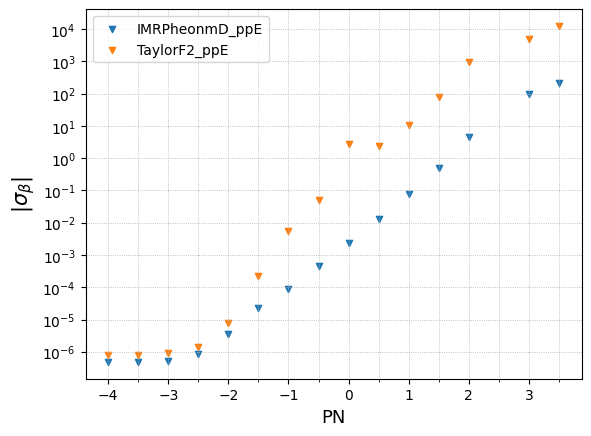

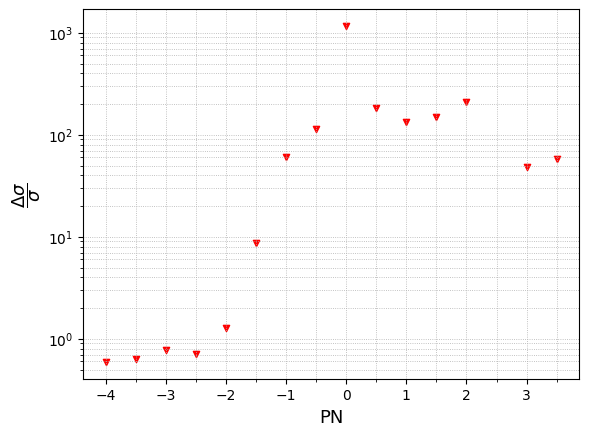

In [36]:
# We do not want to show the 2.5PN result
mask = (x != 2.5)
mask_2 = (x_2 != 2.5)
x = x[mask]
y = y[mask]
x_2 = x_2[mask_2]
y_2 = y_2[mask_2]

fig, ax = plt.subplots()

ax.scatter(x, y, marker='v', s=20, label = 'IMRPheonmD_ppE')
ax.scatter(x_2, y_2, marker='v',  s=20, label = 'TaylorF2_ppE')

ax.set_xlabel('PN', fontsize=13)
ax.set_ylabel('$|\u03C3_{\u03B2}|$', fontsize=15)
ax.legend(loc='upper left', fontsize=10, ncol=1, fancybox=True)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.set_yscale('log')
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=15))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))

plt.savefig('ppE.pdf')
plt.show()
################################################################################

fig, ax = plt.subplots()

delta_sigma = (y_2 - y)/y
ax.scatter(x, delta_sigma, marker='v',  s=20, color = 'red' ,label = r'$\dfrac{\Delta \sigma}{\sigma}$')

ax.set_xlabel('PN', fontsize=13)
ax.set_ylabel(r'$\dfrac{\Delta \sigma}{\sigma}$', fontsize=13)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.set_yscale('log')
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=15))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))

#plt.savefig('ppE_difference.pdf')
plt.show()

#### **0PN correlations: comparison between TF2_ppE and IMR_ppE**

In [37]:
detectors = ['LLO_O1','LHO_O1']

network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_model = 'IMRPhenomD_PPE'
waveform_class = gw.inspiral_corrections.IMRPhenomD_PPE

waveform_model_2 = 'TaylorF2_PPE'
waveform_class_2 = gw.inspiral_corrections.TaylorF2_PPE
PN = 0.
###################################################################################
data_folder = 'gwfish_results'
gw.fishermatrix.analyze_and_save_to_txt(network = network,
                                        parameter_values  = parameters,
                                        fisher_parameters = fisher_parameters,
                                        sub_network_ids_list = [[0,1]],
                                        population_name = 'GW150914',
                                        waveform_class = waveform_class,
                                        waveform_model = waveform_model,
                                        save_path = data_folder,
                                        save_matrices = True)

100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.06s/it]


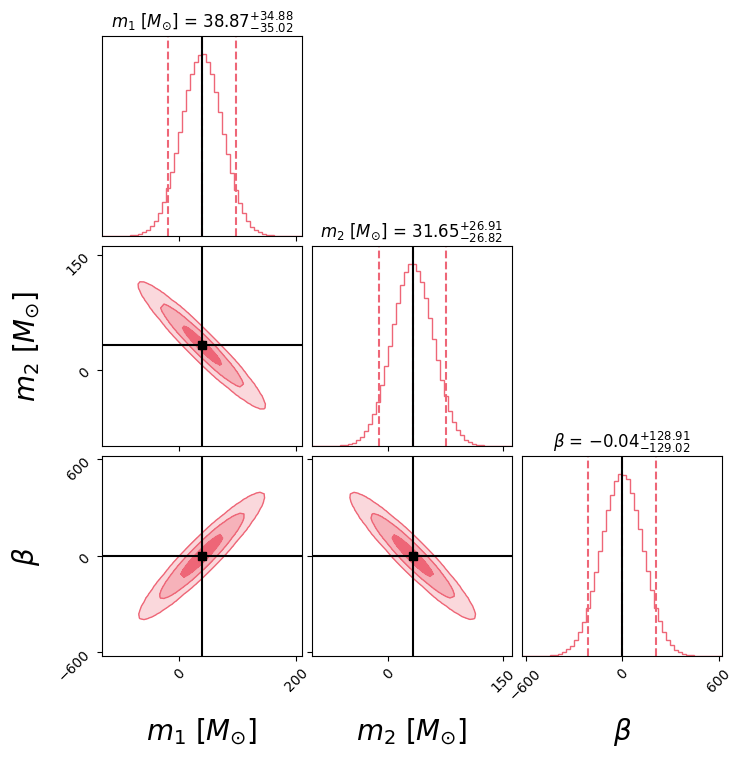

In [39]:
CORNER_KWARGS = dict(
    #color = "#4477AA", #Blue
    #color="#228833", #Green
    color="#EE6677", #Red
    truth_color='black',
    #truth_color='red',
    
    bins = 50, # number of bins for histograms
    smooth = 1.1, # smooths out contours.
    plot_datapoints = False, # choose if you want datapoints
    label_kwargs = dict(fontsize = 20), # font size for labels
    show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = 12), # font size for title
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".2f",
    contour_kwargs={'linewidths':1},
    hist_kwargs = {'linewidth':1},
    quantiles=(0.05,0.5,0.95)
    )

corner_lbs = [r'$m_1$ $[M_{\odot}]$', r'$m_2$ $[M_{\odot}]$',
              '$a_1$', '$a_2$',
              '$t_c$','$\phi_c$',
              '$D_l$ [Mpc]',
              r'$\beta$'
              ]

mean_lbs = ['mass_1', 'mass_2',
            'a_1', 'a_2',
            'geocent_time','phase',
            'luminosity_distance',
            'beta'
            ]

mean_values = parameters[mean_lbs].iloc[0]  #mean values of the parameters
cov_matrix = np.load(data_folder + '/' + 'inv_fisher_matrices_LLO_O1_LHO_O1_GW150914_SNR8.npy')[0, :, :]

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))

################################################################################
# Marginalization
selected_indices = [0, 1, 7]
selected_samples = samples[:, selected_indices]
selected_labels = [corner_lbs[i] for i in selected_indices]
selected_mean_values = mean_values[selected_indices]

fig = corner.corner(selected_samples, labels=selected_labels, truths=selected_mean_values, **CORNER_KWARGS)

#plt.savefig('corner_IMR.pdf')
plt.show()

### *GW150914: comparison between ET vs O5 using the IMR_ppE template*

In [40]:
PN_min = -1.
PN_max = 4.
detectors = ['ET']
detectors_2 = ['LLO','LHO']

network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
network_2 = gw.detection.Network(detector_ids = detectors_2, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_model = 'IMRPhenomD_PPE'
waveform_class = gw.inspiral_corrections.IMRPhenomD_PPE
################################################################################
results = []
results_2 = []

for PN in np.arange(PN_min, PN_max, 0.5):

    parameters['PN'] = PN

    #Errors computation

    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class
    )

    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = gw.fishermatrix.compute_network_errors(
        network=network_2,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class
    )

    err_parameter_of_interest = 1.645 * np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([PN, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = 1.645 * np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([PN, err_parameter_of_interest_2, network_snr_2])


################################################################################
################################################################################

results_df = pd.DataFrame(results, columns=['PN', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['PN', f'err_{parameter_of_interest}_2', 'network_snr_2'])


#Storage
detector_name = '_'.join(detectors)
detector_name_2 = '_'.join(detectors_2)

file_name = f'errors_{detector_name}_{parameter_of_interest}.txt'
file_name_2 = f'errors_{detector_name_2}_{parameter_of_interest}.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.62s/it]


In [41]:
data_2 = np.loadtxt('errors_LLO_LHO_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x_2 = data_2[:, 0]
y_2 = data_2[:, 1]

data_3 = np.loadtxt('errors_ET_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x_3 = data_3[:, 0]
y_3 = data_3[:, 1]

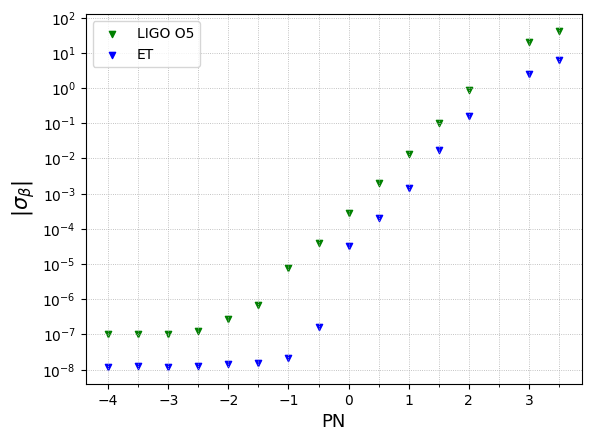

In [48]:
mask_2 = (x_2 != 2.5)
mask_3 = (x_3 != 2.5)

x_2 = x_2[mask_2]
y_2 = y_2[mask_2]

x_3 = x_3[mask_3]
y_3 = y_3[mask_3]

fig, ax = plt.subplots()

ax.scatter(x_2, y_2, color='green', marker='v', s= 20, label = 'LIGO O5')
ax.scatter(x_3, y_3, color='blue', marker='v', s= 20, label = 'ET')

ax.set_xlabel('PN', fontsize=13)
ax.set_ylabel('$|\u03C3_{\u03B2}|$', fontsize=15)
ax.legend(loc='upper left', fontsize=10, ncol=1, fancybox=True)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.set_yscale('log')
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=15))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))

#plt.savefig('ppE.pdf')
plt.show()

### *Constraints as functions of the source-frame total mass BBH mass*

In [3]:
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_class = gw.inspiral_corrections.IMRPhenomD_PPE
waveform_model = 'IMRPhenomD_PPE'

z = 0.088

parameters_1 = {
    'redshift': z,
    'luminosity_distance':np.array([410.]),
    'a_1': np.array([0.32]),
    'a_2': np.array([0.44]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),
    'PN': np.array([-1.]),
    'beta': np.array([0.])
    }
parameters_1 = pd.DataFrame(parameters_1)

parameters_2 = {
    'redshift': z,
    'luminosity_distance':np.array([410.]),
    'a_1': np.array([0.32]),
    'a_2': np.array([0.44]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),
    'PN': np.array([0.]),
    'beta': np.array([0.])
    }
parameters_2 = pd.DataFrame(parameters_2)

parameters_3 = {
    'redshift': z,
    'luminosity_distance':np.array([410.]),
    'a_1': np.array([0.32]),
    'a_2': np.array([0.44]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),
    'PN': np.array([2.]),
    'beta': np.array([0.])
    }
parameters_3 = pd.DataFrame(parameters_3)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance',
                     'phase',
                     'geocent_time',
                     #'theta_jn'
                     #'dec','ra',
                     #'psi',
                     'beta'
                    ]

mass_ratio = 2.
mass_tot_start = 10.
mass_tot_end = 70.
mass_increment = 15.

parameter_of_interest = 'beta'

results = []
results_2 = []
results_3 = []

#Mass values
for mass_tot in np.arange(mass_tot_start, mass_tot_end + 1, mass_increment):

    mass_2 = mass_tot/(1 + mass_ratio)
    mass_1 = mass_2*mass_ratio

    parameters_1['mass_1'] = parameters_2['mass_1'] = parameters_3['mass_1'] = mass_1 * (1 + z)
    parameters_1['mass_2'] = parameters_2['mass_2'] = parameters_3['mass_2'] = mass_2 * (1 + z)

    #Errors computation
    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters_1,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters_2,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )
    detected_3, network_snr_3, parameter_errors_3, sky_localization_3 = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters_3,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )

    err_parameter_of_interest = 1.645*np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([mass_tot, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = 1.645*np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([mass_tot, err_parameter_of_interest_2, network_snr_2])

    err_parameter_of_interest_3 = 1.645*np.squeeze(parameter_errors_3)[fisher_parameters.index(parameter_of_interest)]
    results_3.append([mass_tot, err_parameter_of_interest_3, network_snr_3])

results_df = pd.DataFrame(results, columns=['mass_tot', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['mass_tot', f'err_{parameter_of_interest}_2', 'network_snr_2'])
results_df_3 = pd.DataFrame(results_3, columns=['mass_tot', f'err_{parameter_of_interest}_3', 'network_snr_3'])

#Storage
detector_name = '_'.join(detectors)
file_name = f'errors_{detector_name}_{parameter_of_interest}.txt'
file_name_2 = f'errors_{detector_name}_{parameter_of_interest}_2.txt'
file_name_3 = f'errors_{detector_name}_{parameter_of_interest}_3.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)
results_df_3.to_csv(file_name_3, sep='\t', index=False)

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.27s/it]


In [4]:
data = np.loadtxt('errors_ET_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_ET_'f'{parameter_of_interest}_2.txt', skiprows=1, usecols=(0, 1))

x2 = data_2[:, 0]
y2 = data_2[:, 1]

data_3 = np.loadtxt('errors_ET_'f'{parameter_of_interest}_3.txt', skiprows=1, usecols=(0, 1))

x3 = data_3[:, 0]
y3 = data_3[:, 1]

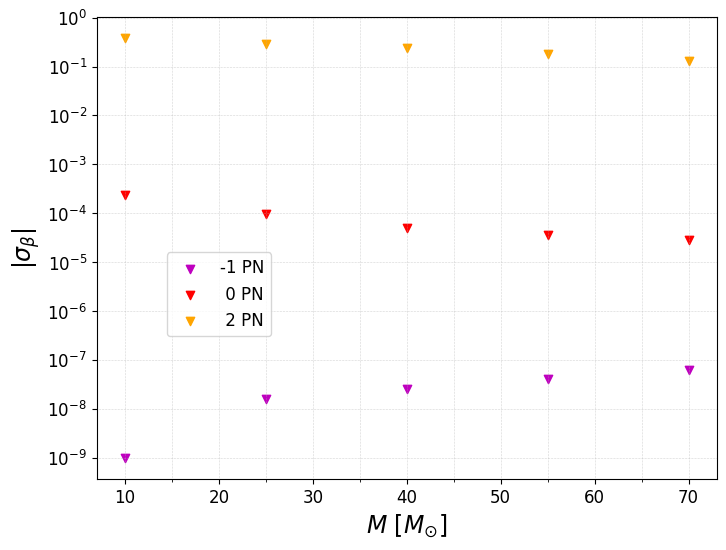

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, marker='v', color='m', label='-1 PN')
ax.scatter(x2, y2, marker='v', color='r', label=' 0 PN')
ax.scatter(x3, y3, marker='v', color='orange', label=' 2 PN')

ax.set_xlabel('$M$ $[M_{\odot}]$', fontsize=17)
ax.set_ylabel('$|\u03C3_{\u03B2}|$', fontsize=17)
#ax.set_ylim(10**1, 10**3)
ax.set_yscale('log')
ax.legend(loc='center left', fontsize=12, ncol=1, fancybox=True, bbox_to_anchor=(0.1, 0.4))
ax.grid(linestyle='dotted', linewidth='0.4', which='both')
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=15))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)

plt.grid(True)
#plt.savefig('beta_vs_M.pdf')
plt.show()

## **Gaussian priors**

### The  ```compute_network_errors_w_priors``` & ```analyze_and_save_to_txt_w_priors``` functions

In [9]:
from typing import Optional, Union
import logging
from pathlib import Path

def compute_network_errors_w_priors(
    network: gw.detection.Network,
    parameter_values: pd.DataFrame,
    fisher_parameters: Optional[list[str]] = None,
    prior_values: Optional[list[float]] = None,
    waveform_model: str = gw.waveforms.DEFAULT_WAVEFORM_MODEL,
    waveform_class : type(gw.waveforms.Waveform) = gw.waveforms.LALFD_Waveform,
    use_duty_cycle: bool = False,
    redefine_tf_vectors: bool = False,
    save_matrices: bool = False,
    save_matrices_path: Union[Path, str] = Path('.'),
    matrix_naming_postfix: str = '',
) -> tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:


    if fisher_parameters is None:
        fisher_parameters = list(parameter_values.keys())

    if 'max_frequency_cutoff' in fisher_parameters:
        fisher_parameters.remove('max_frequency_cutoff')

    if 'redshift' in fisher_parameters:
        fisher_parameters.remove('redshift')

    n_params = len(fisher_parameters)
    n_signals = len(parameter_values)

    assert n_params > 0
    assert n_signals > 0

    if isinstance(save_matrices_path, str):
        save_matrices_path = Path(save_matrices_path)

    if save_matrices:
        save_matrices_path.mkdir(parents=True, exist_ok=True)
        fisher_matrices = np.zeros((n_signals, n_params, n_params))
        inv_fisher_matrices = np.zeros((n_signals, n_params, n_params))

    signals_havesky = False
    if ("ra" in fisher_parameters) and ("dec" in fisher_parameters):
        signals_havesky = True
        i_ra = fisher_parameters.index("ra")
        i_dec = fisher_parameters.index("dec")

    detector_snr_thr, network_snr_thr = network.detection_SNR

    parameter_errors = np.zeros((n_signals, n_params))
    if signals_havesky:
        sky_localization = np.zeros((n_signals,))
    network_snr = np.zeros((n_signals,))

    for k in tqdm(range(n_signals)):

        network_fisher_matrix = np.zeros((n_params, n_params))

        prior_matrix = np.zeros((n_params, n_params))
        for i, value in enumerate(prior_values):
            prior_matrix[i, i] = value

        network_snr_square = 0.

        signal_parameter_values = parameter_values.iloc[k]

        for detector in network.detectors:

            detector_fisher, detector_snr_square = gw.fishermatrix.compute_detector_fisher(
                                                        detector,
                                                        signal_parameter_values,
                                                        fisher_parameters,
                                                        waveform_model,
                                                        waveform_class, use_duty_cycle)

            network_snr_square += detector_snr_square

            if np.sqrt(detector_snr_square) > detector_snr_thr:

                network_fisher_matrix += detector_fisher
                network_fisher_matrix += prior_matrix

        network_fisher_inverse, _ = gw.fishermatrix.invertSVD(network_fisher_matrix)

        if save_matrices:
            fisher_matrices[k, :, :] = network_fisher_matrix
            inv_fisher_matrices[k, :, :] = network_fisher_inverse

        parameter_errors[k, :] = np.sqrt(np.diagonal(network_fisher_inverse))

        network_snr[k] = np.sqrt(network_snr_square)

        if signals_havesky:
            sky_localization[k] = gw.fishermatrix.sky_localization_area(
                network_fisher_inverse, parameter_values["dec"].iloc[k], i_ra, i_dec
            )

    detected, = np.where(network_snr > network_snr_thr)

    if save_matrices:

        if matrix_naming_postfix != '':
            if not matrix_naming_postfix.startswith('_'):
                matrix_naming_postfix = f'_{matrix_naming_postfix}'

        fisher_matrices = fisher_matrices[detected, :, :]
        inv_fisher_matrices = inv_fisher_matrices[detected, :, :]

        np.save(save_matrices_path /  f"fisher_matrices{matrix_naming_postfix}.npy", fisher_matrices)
        np.save(save_matrices_path /  f"inv_fisher_matrices{matrix_naming_postfix}.npy", inv_fisher_matrices)

    if signals_havesky:
        return (
            detected,
            network_snr,
            parameter_errors,
            sky_localization,
        )

    return detected, network_snr, parameter_errors, None
######################################################################################
def analyze_and_save_to_txt_w_priors(
    network: gw.detection.Network,
    parameter_values: pd.DataFrame,
    fisher_parameters: list[str],
    prior_values: list[float],
    sub_network_ids_list: list[list[int]],
    population_name: str,
    save_path: Optional[Union[Path, str]] = None,
    save_matrices: bool = False,
    decimal_output_format: str = '%.3E',
    **kwargs
) -> None:

    if save_path is None:
        save_path = Path().resolve()
    if isinstance(save_path, str):
        save_path = Path(save_path)

    for sub_network_ids in sub_network_ids_list:

        partial_network = network.partial(sub_network_ids)

        filename = gw.fishermatrix.errors_file_name(
            network=network,
            sub_network_ids=sub_network_ids,
            population_name=population_name,
        )

        detected, network_snr, errors, sky_localization = compute_network_errors_w_priors(
            network=partial_network,
            parameter_values=parameter_values,
            fisher_parameters=fisher_parameters,
            prior_values=prior_values,
            save_matrices=save_matrices,
            save_matrices_path=save_path,
            matrix_naming_postfix='_'.join(filename.split('_')[1:]),
            **kwargs,
        )

        gw.fishermatrix.output_to_txt_file(
            parameter_values=parameter_values.iloc[detected],
            network_snr=network_snr[detected],
            parameter_errors=errors[detected, :],
            sky_localization=(
                sky_localization[detected] if sky_localization is not None else None
            ),
            fisher_parameters=fisher_parameters,
            filename=save_path/filename,
            decimal_output_format=decimal_output_format,
        )

### An example

In [10]:
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_model = 'TaylorF2'
waveform_class = gw.waveforms.TaylorF2

z = 0.088

parameters = {
    'mass_1': np.array([35.7]) * (1 + z),  
    'mass_2': np.array([29.1]) * (1 + z),
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,

    'a_1':np.array([0.32]),
    'a_2':np.array([0.34]),

    'theta_jn': np.array([np.radians(138.7)]), #2.4
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),

    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),

    'cut': np.array([1.]) #for TayloF2
}
parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance', 'theta_jn',
                     'phase', 'geocent_time', 'psi'
                     #'dec','ra'
                    ]

# We want to define the 68% width of the Gaussian

delta_m1 = (parameters['mass_1']*0.5)/1.645
prior_m1 = 1/(2*delta_m1**2)
delta_m2 = (parameters['mass_2']*0.5)/1.645
prior_m2 = 1/(2*delta_m2**2)

delta_a1 = (1. - parameters['a_1'])/1.645
prior_a1 = 1/(2*delta_a1**2)
delta_a2 = (1. - parameters['a_2'])/1.645
prior_a2 = 1/(2*delta_a2**2)

delta_dL = 290./1.645
prior_dL = 1/(2*delta_dL**2)
delta_theta_jn = 0.7/1.645
prior_theta_jn = 1/(2*delta_theta_jn**2)

delta_phase = 2.*np.pi/1.645
prior_phase = 1/(2*delta_phase**2)
delta_psi = 2.*np.pi/1.645
prior_psi = 1/(2*delta_phase**2)


prior_values = [prior_m1, prior_m2,
                prior_a1, prior_a2,
                prior_dL, prior_theta_jn,
                prior_phase, prior_psi
                ]

data_folder = 'gwfish_results_w_priors'
analyze_and_save_to_txt_w_priors(network = network,
                                                 parameter_values  = parameters,
                                                 fisher_parameters = fisher_parameters,
                                                 prior_values = prior_values,
                                                 sub_network_ids_list = [[0]],
                                                 population_name = 'Single_event',
                                                 waveform_class = waveform_class,
                                                 waveform_model = waveform_model,
                                                 save_path = data_folder,
                                                 save_matrices = True)

fisher_matrix = np.load(data_folder + '/' + 'fisher_matrices_ET_Single_event_SNR8.npy')
errors = pd.read_csv(data_folder + '/' + 'Errors_ET_Single_event_SNR8.txt', delimiter = ' ')

errors.keys()
errors

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


,network_SNR,mass_1,mass_2,redshift,luminosity_distance,a_1,a_2,theta_jn,ra,dec,...,cut,err_mass_1,err_mass_2,err_a_1,err_a_2,err_luminosity_distance,err_theta_jn,err_phase,err_geocent_time,err_psi
0,934.979073,38.84,31.66,0.088,415.4,0.32,0.34,2.421,1.7,-1.2,...,1.0,6.218,4.859,0.1888,0.2788,2.996,0.009057,1.417,0.002007,0.01372


In [11]:
# If you want to clean your results
import shutil
folder_path = 'gwfish_results_w_priors'
shutil.rmtree(folder_path, ignore_errors=True)

## **gIMR early inspiral deviations**

### *GW150914 LIGO O1 comparison between GWFISH, GWFISH w priors, and BILBY*

In [24]:
detectors = ['LLO_O1','LHO_O1']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True

waveform_model = 'TaylorF2_PPE'
waveform_class = gw.inspiral_corrections.TaylorF2_PPE

z = np.array([0.088])

custom_order = [10, 0, 1, 2, 3, 4, 8, 6, 9, 7]

results = []
results_2 = []

for i in custom_order:

    parameter_of_interest = f'delta_phi_{i}'

    parameters = {
    'mass_1': np.array([35.7]) * (1 + z),  
    'mass_2': np.array([29.1]) * (1 + z), 
    'redshift': z,
    'luminosity_distance': np.array([410.]),
    'a_1': np.array([0.32]),
    'a_2': np.array([0.44]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),
    'cut': np.array([1.]),
    f'delta_phi_{i}': np.array([0.])
    }
    parameters = pd.DataFrame(parameters)

    fisher_parameters = ['mass_1', 'mass_2',
                        'a_1', 'a_2',
                        'luminosity_distance',
                        'phase',
                        #'geocent_time',
                        'theta_jn',
                        #'dec','ra',
                        #'psi',
                        f'delta_phi_{i}'
                        ]
    
    delta_m1 = (parameters['mass_1']*0.5)/1.645
    prior_m1 = 1/(2*delta_m1**2)
    delta_m2 = (parameters['mass_2']*0.5)/1.645
    prior_m2 = 1/(2*delta_m2**2)

    delta_a1 = (1. - parameters['a_1'])/1.645
    prior_a1 = 1/(2*delta_a1**2)
    delta_a2 = (1. - parameters['a_2'])/1.645
    prior_a2 = 1/(2*delta_a2**2)

    delta_dL = 290./1.645
    prior_dL = 1/(2*delta_dL**2)
    delta_theta_jn = 0.7/1.645
    prior_theta_jn = 1/(2*delta_theta_jn**2)

    delta_phase = 2.*np.pi/1.645
    prior_phase = 1/(2*delta_phase**2)
    delta_delta_phi = 20./1.645
    prior_delta_phi = 1/(2*delta_delta_phi**2)


    prior_values = [prior_m1, prior_m2,
                    prior_a1, prior_a2,
                    prior_dL, prior_theta_jn,
                    prior_phase, prior_delta_phi
                    ]
    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class
    )

# Before doing that, load the cell with the compute_network_errors_w_priors function 
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = compute_network_errors_w_priors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values=prior_values,
        waveform_model=waveform_model,
        waveform_class=waveform_class
    )

    err_parameter_of_interest = 1.645 * np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([i, err_parameter_of_interest, network_snr])
    
    err_parameter_of_interest_2 = 1.645 * np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([i, err_parameter_of_interest_2, network_snr_2])

results_df = pd.DataFrame(results, columns=['i', f'err_delta_phi', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['i', f'err_delta_phi', 'network_snr'])
detector_name = '_'.join(detectors_3)
file_name = f'errors_{detector_name}_delta_phi.txt'
file_name_2 = f'errors_{detector_name}_delta_phi_w_priors.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

#delta_phi_8=delta_phi_2.5log
#delta_phi_9=delta_phi_3log
#delta_phi_10=delta_phi_-2

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


In [27]:
data = np.loadtxt('errors_LLO_O1_LHO_O1_delta_phi.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

# Upload the BIBLY results
"""
data_2 = np.loadtxt('ppE LIGO O1.txt', skiprows=1, usecols=(0, 1))

x_2 = data_2[:, 0]
y_2 = data_2[:, 1]
"""
data_3 = np.loadtxt('errors_LLO_O1_LHO_O1_delta_phi_w_priors.txt', skiprows=1, usecols=(0, 1))

x_3 = data_3[:, 0]
y_3 = data_3[:, 1]

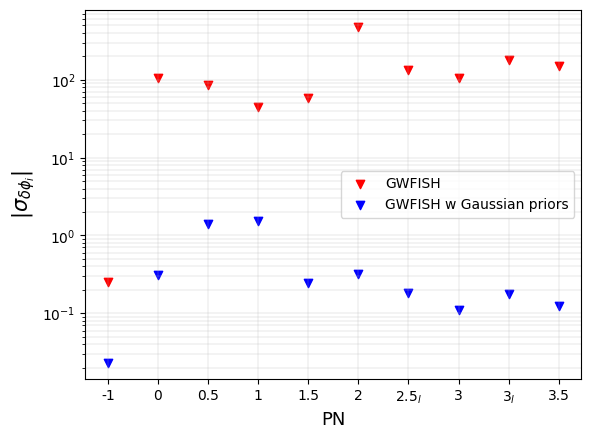

In [28]:
custom_x_labels = [ '-1', '0', '0.5', '1', '1.5', '2', '2.5$_{l}$', '3', '3$_{l}$', '3.5']

fig, ax = plt.subplots()

ax.scatter(x, y, color='red', marker='v', label = 'GWFISH')
ax.scatter(x_3, y_3, color='blue', marker='v' ,label = 'GWFISH w Gaussian priors')
#ax.scatter(x_2, y_2, color='blue', marker='s', facecolors='none' ,label = 'BILBY')

ax.set_xlabel('PN', fontsize=13)
ax.set_ylabel('$|\u03C3_{\delta \phi_i}|$', fontsize=15)
ax.legend(loc='center right', fontsize=10, ncol=1, fancybox=True)
plt.grid(linestyle='-', linewidth='0.2', which='both')
ax.set_xticks(x)
ax.set_xticklabels(custom_x_labels)
ax.set_yscale('log')

#plt.savefig('ppE_GWFISH_vs_BILBY.pdf')
plt.show()

### *GW150914 comparison between ET vs LIGO/CE*

In [ ]:
detectors = ['ET']
detectors_2 = ['LLO','LHO']
detectors_3 = ['CE1', 'CE2']

network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
network_2 = gw.detection.Network(detector_ids = detectors_2, detection_SNR = (0., 8.))
network_3 = gw.detection.Network(detector_ids = detectors_3, detection_SNR = (0., 8.))


waveform_model = 'IMRPhenomD_PPE'
waveform_class = gw.inspiral_corrections.IMRPhenomD_PPE

z = np.array([0.088])

custom_order = [10, 0, 1, 2, 3, 4, 8, 6, 9, 7]

results = []
results_2 = []
results_3 = []

for i in custom_order:

    parameter_of_interest = f'delta_phi_{i}'

    parameters = {
    'mass_1': np.array([35.7]) * (1 + z),  #detector frame
    'mass_2': np.array([29.1]) * (1 + z),  #detector frame
    'redshift': z,
    'luminosity_distance':np.array([410.]),
    'a_1': np.array([0.32]),
    'a_2': np.array([0.44]),
    'theta_jn': np.array([np.radians(138.7)]),
    'ra': np.array([1.7]),
    'dec': np.array([-1.2]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1126259462.4]),
    'cut': np.array([1.]),
    f'delta_phi_{i}': np.array([0.])
    }
    parameters = pd.DataFrame(parameters)

    fisher_parameters = ['mass_1', 'mass_2',
                        'a_1', 'a_2',
                        'luminosity_distance',
                        'phase',
                        #'geocent_time',
                        'theta_jn',
                        #'dec','ra',
                        #'psi',
                        f'delta_phi_{i}'
                        ]

    delta_m1 = (parameters['mass_1']*0.5)/1.645
    prior_m1 = 1/(2*delta_m1**2)
    delta_m2 = (parameters['mass_2']*0.5)/1.645
    prior_m2 = 1/(2*delta_m2**2)

    delta_a1 = (1. - parameters['a_1'])/1.645
    prior_a1 = 1/(2*delta_a1**2)
    delta_a2 = (1. - parameters['a_2'])/1.645
    prior_a2 = 1/(2*delta_a2**2)

    delta_dL = 290./1.645
    prior_dL = 1/(2*delta_dL**2)
    delta_theta_jn = 0.7/1.645
    prior_theta_jn = 1/(2*delta_theta_jn**2)

    delta_phase = 2.*np.pi/1.645
    prior_phase = 1/(2*delta_phase**2)

    delta_phi = 20/1.645
    prior_phi = 1/(2*delta_phi**2)

    prior_values = [prior_m1, prior_m2,
                    prior_a1, prior_a2,
                    prior_dL, prior_theta,
                    prior_phase,
                    prior_phi
                    #0.]
    ]

    #Errors computation
    detected, network_snr, parameter_errors, sky_localization = compute_network_errors_w_priors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values=prior_values,
        waveform_model=waveform_model,
        waveform_class=waveform_class
    )
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = compute_network_errors_w_priors(
        network=network_2,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values=prior_values,
        waveform_model=waveform_model,
        waveform_class=waveform_class
    )

    detected_3, network_snr_3, parameter_errors_3, sky_localization_3 = compute_network_errors_w_priors(
        network=network_3,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values=prior_values,
        waveform_model=waveform_model,
        waveform_class=waveform_class
    )

    err_parameter_of_interest = 1.645 * np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([i, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = 1.645 * np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([i, err_parameter_of_interest_2, network_snr_2])

    err_parameter_of_interest_3 = 1.645 * np.squeeze(parameter_errors_3)[fisher_parameters.index(parameter_of_interest)]
    results_3.append([i, err_parameter_of_interest_3, network_snr_3])

results_df = pd.DataFrame(results, columns=['i', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['i', f'err_{parameter_of_interest}_2', 'network_snr_2'])
results_df_3 = pd.DataFrame(results_3, columns=['i', f'err_{parameter_of_interest}_3', 'network_snr_3'])
detector_name = '_'.join(detectors)
detector_name_2 = '_'.join(detectors_2)
detector_name_3 = '_'.join(detectors_3)
file_name = f'errors_{detector_name}_delta_phi.txt'
file_name_2 = f'errors_{detector_name_2}_delta_phi.txt'
file_name_3 = f'errors_{detector_name_3}_delta_phi.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)
results_df_3.to_csv(file_name_3, sep='\t', index=False)

100%|██████████| 1/1 [00:11<00:00, 11.49s/it]


In [ ]:
data = np.loadtxt('errors_ET_delta_phi.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_LLO_LHO_delta_phi.txt', skiprows=1, usecols=(0, 1))

x_2 = data_2[:, 0]
y_2 = data_2[:, 1]

data_3 = np.loadtxt('errors_CE1_CE2_delta_phi.txt', skiprows=1, usecols=(0, 1))

x_3 = data_3[:, 0]
y_3 = data_3[:, 1]

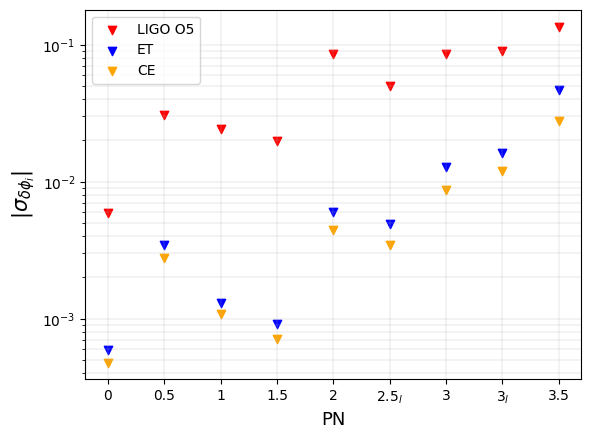

In [ ]:
custom_x_labels = [ '0', '0.5', '1', '1.5', '2', '2.5$_{l}$', '3', '3$_{l}$', '3.5']

fig, ax = plt.subplots()

ax.scatter(x, y, color='blue', marker='v', label = 'ET')
ax.scatter(x_2, y_2, color='red', marker='v', label = 'LIGO O5')
ax.scatter(x_3, y_3, color='orange', marker='v', label = 'CE')

ax.set_xlabel('PN', fontsize=13)
ax.set_ylabel('$|\u03C3_{\delta \phi_i}|$', fontsize=15)
ax.legend(loc='upper left', fontsize=10, ncol=1, fancybox=True)
plt.grid(linestyle='-', linewidth='0.2', which='both')
ax.set_xticks(x_2)
ax.set_xticklabels(custom_x_labels)
ax.set_yscale('log')

#plt.savefig('ppE_O5vsETvsCE.pdf')
plt.show()

## **Multipolar deviations in a series of events...**

In [18]:
detectors = ['ET']
detectors_2 = ['LLO','LHO']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
network_2 = gw.detection.Network(detector_ids = detectors_2, detection_SNR = (0., 8.))
use_duty_cycle = True

def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value

dL = 400.
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]
tc = 1126259462.4

parameters = {
    'luminosity_distance': np.array([dL]),
    'theta_jn': np.array([np.radians(60.)]),
    'ra': np.array([4.]),
    'dec': np.array([-0.5]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),
    'cut': np.array([2.]),
    'k_1': np.array([0.]),
    'k_2': np.array([0.]),
    'lambda_1': np.array([0.]),
    'lambda_2': np.array([0.]),
    'tilde': np.array([0.]),
    'delta_tilde': np.array([0.])
}
parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase',
                     #'geocent_time',
                     'luminosity_distance',
                     'theta_jn',
                     #'lambda_1',
                     #'lambda_2'
                     #'k_2',
                     'k_1'
                     ]

waveform_class = gw.inspiral_corrections.TaylorF2_mult
waveform_model = 'TaylorF2_mult'

parameter_of_interest = 'k_1'

### **...with differet source frame total mass**

In [22]:
mass_ratio = 3.
mass_tot_start = 10.
mass_tot_end = 70.
mass_increment = 15.

parameters['a_1'] = 0.9
parameters['a_2'] = 0.8

results = []
results_2 = []

#Mass values
for mass_tot in np.arange(mass_tot_start, mass_tot_end + 1., mass_increment):


    mass_2 = mass_tot/(1 + mass_ratio)
    mass_1 = mass_2*mass_ratio

    parameters['mass_1'] = mass_1 * (1 + z)
    parameters['mass_2'] = mass_2 * (1 + z)

    delta_m1 = (parameters['mass_1']*0.5)/1.645
    prior_m1 = 1/(2*delta_m1**2)
    delta_m2 = (parameters['mass_2']*0.5)/1.645
    prior_m2 = 1/(2*delta_m2**2)

    delta_a1 = (1. - parameters['a_1'])/1.645
    prior_a1 = 1/(2*delta_a1**2)
    delta_a2 = (1. - parameters['a_2'])/1.645
    prior_a2 = 1/(2*delta_a2**2)

    delta_dL = 290./1.645
    prior_dL = 1/(2*delta_dL**2)
    delta_theta_jn = 0.7/1.645
    prior_theta_jn = 1/(2*delta_theta_jn**2)

    delta_phase = 2.*np.pi/1.645
    prior_phase = 1/(2*delta_phase**2)

    prior_values = [prior_m1, prior_m2,
                    prior_a1, prior_a2,
                    prior_dL, prior_theta_jn,
                    prior_phase,
                    0.]

    #Errors computation
    detected, network_snr, parameter_errors, sky_localization = compute_network_errors_w_priors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values = prior_values,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = compute_network_errors_w_priors(
        network=network_2,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values = prior_values,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )

    err_parameter_of_interest = np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([mass_tot, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([mass_tot, err_parameter_of_interest_2, network_snr_2])

results_df = pd.DataFrame(results, columns=['mass_tot', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['mass_tot', f'err_{parameter_of_interest}_2', 'network_snr_2'])

#Storage
detector_name = '_'.join(detectors)
detector_name_2 = '_'.join(detectors_2)
file_name = f'errors_{detector_name}_{parameter_of_interest}_w_priors.txt'
file_name_2 = f'errors_{detector_name_2}_{parameter_of_interest}_w_priors.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


In [23]:
data = np.loadtxt('errors_ET_'f'{parameter_of_interest}_w_priors.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_LLO_LHO_'f'{parameter_of_interest}_w_priors.txt', skiprows=1, usecols=(0, 1))

x2 = data_2[:, 0]
y2 = data_2[:, 1]

#Bayesian results
"""
data= np.loadtxt('quadrupole ET.txt', skiprows=1, usecols=(0, 1))

x3 = data[:, 0]
y3 = data[:, 1]

data_2 = np.loadtxt('quadrupole O5.txt', skiprows=1, usecols=(0, 1))

x4 = data_2[:, 0]
y4 = data_2[:, 1]
"""

"\ndata= np.loadtxt('quadrupole ET.txt', skiprows=1, usecols=(0, 1))\n\nx3 = data[:, 0]\ny3 = data[:, 1]\n\ndata_2 = np.loadtxt('quadrupole O5.txt', skiprows=1, usecols=(0, 1))\n\nx4 = data_2[:, 0]\ny4 = data_2[:, 1]\n"

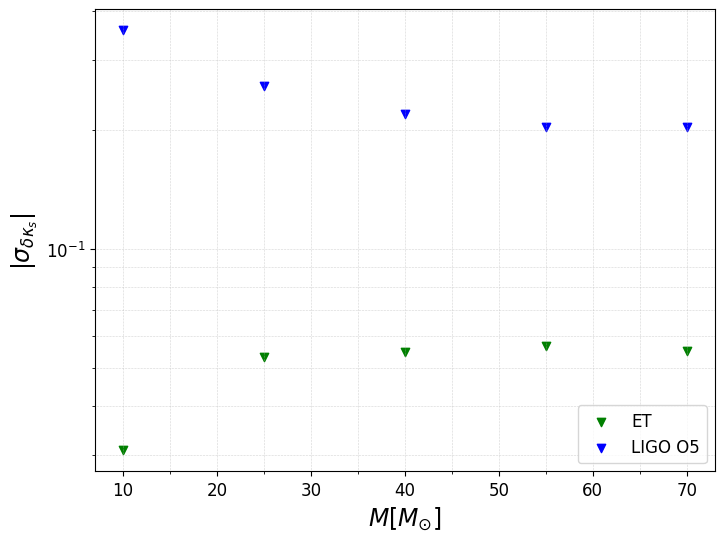

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, marker='v', color='g', label='ET')
ax.scatter(x2, y2, marker='v', color='b',label='LIGO O5')

ax.set_xlabel('$M [M_{\odot}]$', fontsize=17)
ax.set_ylabel('$|\u03C3_{\delta \kappa_s}|$', fontsize=17)
ax.set_yscale('log')
ax.legend(loc='lower right', fontsize=12, ncol=1, fancybox=True)
ax.grid(linestyle='dotted', linewidth='0.4', which='both')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)

plt.grid(True)
#plt.savefig(f'_{parameter_of_interest}''_ETvsO5_mul.pdf')
plt.show()

### **...with differet total spin**

In [30]:
mass_ratio = 3.
mass_tot = 70.
mass_2 = mass_tot/(1 + mass_ratio)
mass_1 = mass_2*mass_ratio
parameters['mass_1'] = mass_1 * (1 + z)
parameters['mass_2'] = mass_2 * (1 + z)

spin_ratio = 5./4.
spin_tot_start = 0.1
spin_tot_end = 1.
spin_increment = 0.2

results = []
results_2 = []

#Mass values
for spin_tot in np.arange(spin_tot_start, spin_tot_end + .1, spin_increment):

    a_2 = spin_tot/(1 + spin_ratio)
    a_1 = a_2*spin_ratio

    parameters['a_1'] = a_1
    parameters['a_2'] = a_2

    delta_m1 = (parameters['mass_1']*0.5)/1.645
    prior_m1 = 1/(2*delta_m1**2)
    delta_m2 = (parameters['mass_2']*0.5)/1.645
    prior_m2 = 1/(2*delta_m2**2)

    delta_a1 = (1. - parameters['a_1'])/1.645
    prior_a1 = 1/(2*delta_a1**2)
    delta_a2 = (1. - parameters['a_2'])/1.645
    prior_a2 = 1/(2*delta_a2**2)

    delta_dL = 290./1.645
    prior_dL = 1/(2*delta_dL**2)
    delta_theta_jn = 0.7/1.645
    prior_theta_jn = 1/(2*delta_theta_jn**2)

    delta_phase = 2.*np.pi/1.645
    prior_phase = 1/(2*delta_phase**2)

    prior_values = [prior_m1, prior_m2,
                    prior_a1, prior_a2,
                    prior_dL, prior_theta_jn,
                    prior_phase,
                    0.]

    #Errors computation
    detected, network_snr, parameter_errors, sky_localization = compute_network_errors_w_priors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values = prior_values,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = compute_network_errors_w_priors(
        network=network_2,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values = prior_values,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )

    err_parameter_of_interest = np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([spin_tot, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([spin_tot, err_parameter_of_interest_2, network_snr_2])

results_df = pd.DataFrame(results, columns=['spin_tot', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['spin_tot', f'err_{parameter_of_interest}_2', 'network_snr_2'])

#Storage
detector_name = '_'.join(detectors)
detector_name_2 = '_'.join(detectors_2)
file_name = f'errors_{detector_name}_{parameter_of_interest}_w_priors.txt'
file_name_2 = f'errors_{detector_name_2}_{parameter_of_interest}_w_priors.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


In [31]:
data = np.loadtxt('errors_ET_'f'{parameter_of_interest}_w_priors.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_LLO_LHO_'f'{parameter_of_interest}_w_priors.txt', skiprows=1, usecols=(0, 1))

x2 = data_2[:, 0]
y2 = data_2[:, 1]

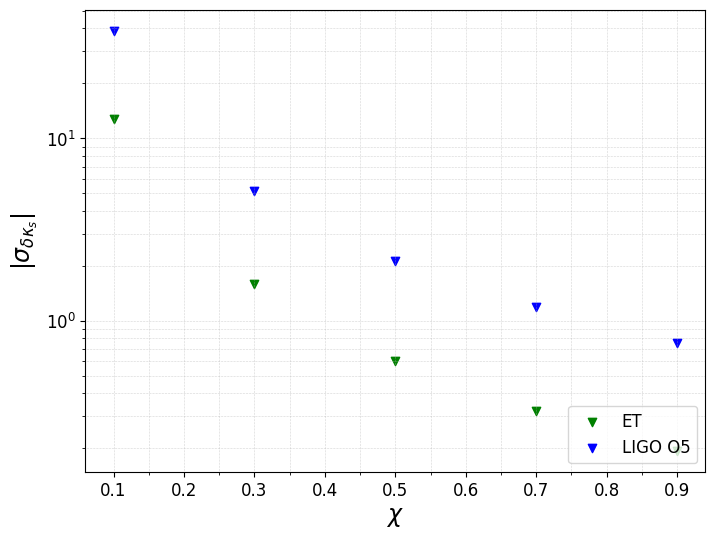

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, marker='v', color='g', label='ET')
ax.scatter(x2, y2, marker='v', color='b',label='LIGO O5')

ax.set_xlabel('$\chi$', fontsize=17)
ax.set_ylabel('$|\u03C3_{\delta \kappa_s}|$', fontsize=17)
ax.set_yscale('log')
ax.legend(loc='lower right', fontsize=12, ncol=1, fancybox=True)
ax.grid(linestyle='dotted', linewidth='0.4', which='both')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)

plt.grid(True)
#plt.savefig(f'_{parameter_of_interest}''_ETvsO5_mul.pdf')
plt.show()

## **Tidal deviations in a series of events**

In [33]:
detectors = ['ET']
detectors_2 = ['LLO','LHO']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
network_2 = gw.detection.Network(detector_ids = detectors_2, detection_SNR = (0., 8.))
use_duty_cycle = True

def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value

dL = 400.
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]
tc = 1126259462.4

parameters = {
    'luminosity_distance': np.array([dL]),
    'a_1': np.array([0.]),
    'a_2': np.array([0.]),
    'theta_jn': np.array([np.radians(60.)]),
    'ra': np.array([4.]),
    'dec': np.array([-0.5]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),
    'cut': np.array([2.]),
    'k_1': np.array([0.]),
    'k_2': np.array([0.]),
    'lambda_1': np.array([0.]),
    'lambda_2': np.array([0.]),
    'tilde': np.array([0.]),
    'delta_tilde': np.array([0.])
}
parameters = pd.DataFrame(parameters)

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase',
                     #'geocent_time',
                     'luminosity_distance',
                     'theta_jn',
                     #'delta_tilde'
                     'tilde'
                     ]

waveform_class = gw.inspiral_corrections.TaylorF2_mult
waveform_model = 'TaylorF2_mult'

parameter_of_interest = 'tilde'

In [35]:
mass_ratio = 3.
mass_tot_start = 10.
mass_tot_end = 70.
mass_increment = 15.

results = []
results_2 = []

for mass_tot in np.arange(mass_tot_start, mass_tot_end + 1, mass_increment):

    mass_2 = mass_tot/(1 + mass_ratio)
    mass_1 = mass_2*mass_ratio
    parameters['mass_1'] = mass_1 * (1 + z)
    parameters['mass_2'] = mass_2 * (1 + z)

    delta_m1 = (parameters['mass_1']*0.5)/1.645
    prior_m1 = 1/(2*delta_m1**2)
    delta_m2 = (parameters['mass_2']*0.5)/1.645
    prior_m2 = 1/(2*delta_m2**2)

    delta_a1 = (1. - parameters['a_1'])/1.645
    prior_a1 = 1/(2*delta_a1**2)
    delta_a2 = (1. - parameters['a_2'])/1.645
    prior_a2 = 1/(2*delta_a2**2)

    delta_dL = 290./1.645
    prior_dL = 1/(2*delta_dL**2)
    delta_theta_jn = 0.7/1.645
    prior_theta_jn = 1/(2*delta_theta_jn**2)

    delta_phase = 2.*np.pi/1.645
    prior_phase = 1/(2*delta_phase**2)

    delta_lambda = 200/1.645
    prior_lambda = 1/(2*delta_lambda**2)

    prior_values = [prior_m1, prior_m2,
                    prior_a1, prior_a2,
                    prior_dL, prior_theta_jn,
                    prior_phase,
                    prior_lambda
                    #0.]
    ]

    detected, network_snr, parameter_errors, sky_localization = compute_network_errors_w_priors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values=prior_values,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )
    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = compute_network_errors_w_priors(
        network=network_2,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        prior_values=prior_values,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )

    err_parameter_of_interest = np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([mass_tot, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = np.squeeze(parameter_errors_2)[fisher_parameters.index(parameter_of_interest)]
    results_2.append([mass_tot, err_parameter_of_interest_2, network_snr_2])

results_df = pd.DataFrame(results, columns=['mass_tot', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['mass_tot', f'err_{parameter_of_interest}_2', 'network_snr_2'])

detector_name = '_'.join(detectors)
detector_name_2 = '_'.join(detectors_2)
file_name = f'errors_{detector_name}_{parameter_of_interest}_w_priors.txt'
file_name_2 = f'errors_{detector_name_2}_{parameter_of_interest}_w_priors.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


In [36]:
data = np.loadtxt('errors_ET_'f'{parameter_of_interest}_w_priors.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_LLO_LHO_'f'{parameter_of_interest}_w_priors.txt', skiprows=1, usecols=(0, 1))

x2 = data_2[:, 0]
y2 = data_2[:, 1]

#Bayesian results
"""
data= np.loadtxt('tidal 5PN fixed spin gaussian ET.txt', skiprows=1, usecols=(0, 1))

x3 = data[:, 0]
y3 = data[:, 1]

data_2 = np.loadtxt('tidal 5PN fixed spin gaussian O5.txt', skiprows=1, usecols=(0, 1))

x4 = data_2[:, 0]
y4 = data_2[:, 1]
"""

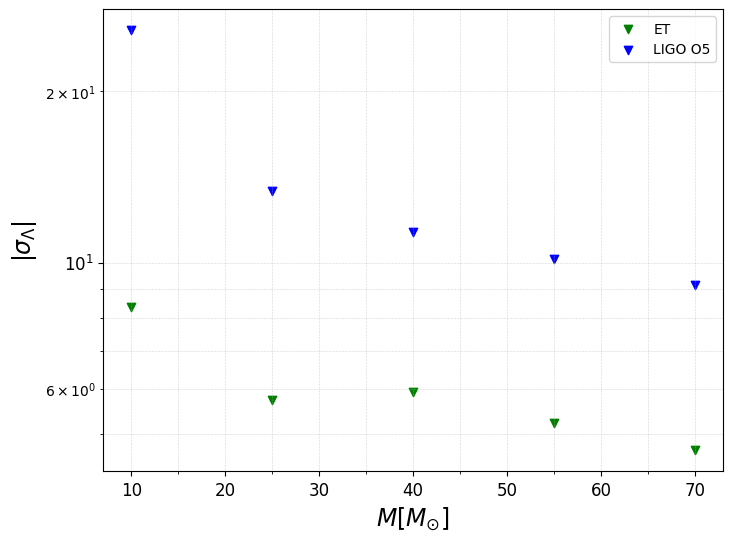

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, marker='v', color='g', label='ET')
ax.scatter(x2, y2, marker='v', color='b', label='LIGO O5')

ax.set_xlabel('$M [M_{\odot}]$', fontsize=17)
ax.set_ylabel('$|\u03C3_{\Lambda}|$', fontsize=17)
ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=10, ncol=1, fancybox=True)
ax.grid(linestyle='dotted', linewidth='0.4', which='both')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)

plt.grid(True)
#plt.savefig('tidal_ETvsO5.pdf')
plt.show()

In [ ]:
detectors = ['LLO','LHO']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True # default is False anyway

from scipy.optimize import fsolve
def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value

# Definisci la distanza di luminosità (in Mpc)
dL = 400.

# Definisci il redshift
z = 0.088

tc = 1126259462.4

# Definizione dei parametri

parameters = {
    'redshift': z,
    'luminosity_distance': np.array([dL]),

    'a_1':np.array([0.9]),
    'a_2':np.array([0.8]),

    'theta_jn': np.array([np.radians(60.)]),
    'ra': np.array([4.]),
    'dec': np.array([-0.5]),

    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),

    'cut': np.array([2.]),

    'k_1': np.array([0.]),
    'k_2': np.array([0.]),
    'lambda_1': np.array([0.]),
    'lambda_2': np.array([0.]),
    'tilde': np.array([0.]),
    'delta_tilde': np.array([0.])
}
parameters = pd.DataFrame(parameters)


# Definizione di eventuali valori di mass ratio e massa totale
mass_ratio = 3.
mass_tot = 25.

# Calcolo di mass_2 basato sul rapporto di massa
mass_2 = mass_tot/(1 + mass_ratio)
mass_1 = mass_2*mass_ratio

# Ricerca della radice dell'equazione redshift-distanza di luminosità
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]

# Aggiornamento dei parametri con i nuovi valori di massa
parameters['mass_1'] = mass_1 * (1 + z)
parameters['mass_2'] = mass_2 * (1 + z)


fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase',
                     'geocent_time',
                     'luminosity_distance',
                     'theta_jn',
                     'k_1'
                     ]


fisher_parameters_2 = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'phase',
                     #'geocent_time',
                     'luminosity_distance',
                     'theta_jn',
                     'k_1'
                     ]


waveform_class = gw.inspiral_corrections.TaylorF2_mult
waveform_model = 'TaylorF2_mult'


detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
network=network,
parameter_values=parameters,
fisher_parameters=fisher_parameters,
waveform_model = waveform_model,
waveform_class = waveform_class
)
err_k_1 = np.squeeze(parameter_errors)[fisher_parameters.index('k_1')]

detected, network_snr_2, parameter_errors_2, sky_localization = gw.fishermatrix.compute_network_errors(
network=network,
parameter_values=parameters,
fisher_parameters=fisher_parameters_2,
waveform_model = waveform_model,
waveform_class = waveform_class
)
err_k_1_wo_tc = np.squeeze(parameter_errors_2)[fisher_parameters_2.index('k_1')]


################################################################################
print('\n      z =', z)
print('\n      M [M_sol] =', mass_tot, '      q =', mass_ratio)
print('\n      a_1 =', parameters['a_1'].values[0], '      a_2 =', parameters['a_2'].values[0])
print('\n      d_l [Mpc] =', parameters['luminosity_distance'].values[0], '      theta_jn [rad]=', parameters['theta_jn'].values[0])
print('\n      ra [rad] =', parameters['ra'].values[0], '      dec [rad] =', parameters['dec'].values[0])
print('\n      phi_c =', parameters['phase'].values[0], '      t_c =', parameters['geocent_time'].values[0])

print('\n\n The network SNR of the event is', network_snr)
print('\n\n The symmetric quadrupole deviation error of the event is')
print('\n\n delta k_s =', err_k_1)

print('\n\n The network SNR of the event, at fixed t_c, is', network_snr_2)
print('\n\n The symmetric quadrupole deviation error, at fixed t_c, of the event is')
print('\n\n delta k_s =', err_k_1_wo_tc)

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


      z = 0.08491816057699987

      M [M_sol] = 25.0       q = 3.0

      a_1 = 0.9       a_2 = 0.8

      d_l [Mpc] = 400.0       theta_jn [rad]= 1.0471975511965976

      ra [rad] = 4.0       dec [rad] = -0.5

      phi_c = 0.0       t_c = 1126259462.4


 The network SNR of the event is [67.71625989]


 The symmetric quadrupole deviation error of the event is


 delta k_s = 0.7467540553019053


 The network SNR of the event, at fixed t_c, is [67.71625989]


 The symmetric quadrupole deviation error, at fixed t_c, of the event is


 delta k_s = 0.5177160370722665


In [ ]:
detectors = ['ET']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
use_duty_cycle = True # default is False anyway

from scipy.optimize import fsolve

def redshift_equation(z, dL, cosmology):
    return dL - cosmology.luminosity_distance(z).value

# Definisci il geocent_time
#tc = 1126259462.4
tc = 0.

dL = 400.
z = fsolve(redshift_equation, x0=0.1, args=(dL, Planck18))[0]

parameters = {
    'luminosity_distance': np.array([dL]),
    'a_1':np.array([0.9]),
    'a_2':np.array([0.8]),
    'theta_jn': np.array([np.radians(60.)]),
    'ra': np.array([4.]),
    'dec': np.array([-0.5]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([tc]),
    'cut': np.array([2.]),

    'k_1': np.array([0.]),
    'k_2': np.array([0.]),
    'lambda_1': np.array([0.]),
    'lambda_2': np.array([0.]),
    'tilde': np.array([0.]),
    'delta_tilde': np.array([0.])
}

parameters = pd.DataFrame(parameters)

#Fisher parameters dictionary

fisher_parameters = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance',
                     'theta_jn',
                     'phase', 'geocent_time',
                     #'dec','ra',
                     #'psi',
                     #'k_1'
                    ]

fisher_parameters_2 = ['mass_1', 'mass_2',
                     'a_1', 'a_2',
                     'luminosity_distance',
                     'theta_jn',
                     'phase',
                     #'dec','ra',
                     #'psi',
                     #'k_1'
                    ]

waveform_class = gw.waveforms.LALFD_Waveform
waveform_model = 'TaylorF2'

# Definizione dei valori di massa
mass_ratio = 3.
mass_tot_start = 10.
mass_tot_end = 70.
mass_increment = 15.

# Inizializzazione della lista per memorizzare i risultati
results = []
results_2 = []

# Iterazione su mass_1
for mass_tot in np.arange(mass_tot_start, mass_tot_end + 1, mass_increment):

    # Calcolo di mass_1 e mass_2 basato su q e M
    mass_2 = mass_tot/(1 + mass_ratio)
    mass_1 = mass_2*mass_ratio

    # Aggiornamento dei parametri con i nuovi valori di massa
    parameters['mass_1'] = mass_1 * (1 + z)
    parameters['mass_2'] = mass_2 * (1 + z)

    # Calcolo degli errori sui parametri con i nuovi valori di massa
    detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )

    detected_2, network_snr_2, parameter_errors_2, sky_localization_2 = gw.fishermatrix.compute_network_errors(
        network=network,
        parameter_values=parameters,
        fisher_parameters=fisher_parameters_2,
        waveform_model=waveform_model,
        waveform_class=waveform_class,
    )

    # Definisci il parametro su cui calcolare gli errori
    parameter_of_interest = 'mass_1'

    err_parameter_of_interest = np.squeeze(parameter_errors)[fisher_parameters.index(parameter_of_interest)]
    results.append([mass_tot, err_parameter_of_interest, network_snr])

    err_parameter_of_interest_2 = np.squeeze(parameter_errors_2)[fisher_parameters_2.index(parameter_of_interest)]
    results_2.append([mass_tot, err_parameter_of_interest_2, network_snr_2])

results_df = pd.DataFrame(results, columns=['mass_tot', f'err_{parameter_of_interest}', 'network_snr'])
results_df_2 = pd.DataFrame(results_2, columns=['mass_tot', f'err_{parameter_of_interest}_2', 'network_snr_2'])

# Salva i risultati in un file di testo .txt
file_name = f'errors_w_geocent_time_{parameter_of_interest}.txt'
file_name_2 = f'errors_wo_geocent_time_{parameter_of_interest}.txt'

results_df.to_csv(file_name, sep='\t', index=False)
results_df_2.to_csv(file_name_2, sep='\t', index=False)

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


In [ ]:
data = np.loadtxt('errors_w_geocent_time_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x = data[:, 0]
y = data[:, 1]

data_2 = np.loadtxt('errors_wo_geocent_time_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x2 = data_2[:, 0]
y2 = data_2[:, 1]

In [ ]:
data = np.loadtxt('errors_w_geocent_time_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x3 = data[:, 0]
y3 = data[:, 1]

data_2 = np.loadtxt('errors_wo_geocent_time_'f'{parameter_of_interest}.txt', skiprows=1, usecols=(0, 1))

x4 = data_2[:, 0]
y4 = data_2[:, 1]

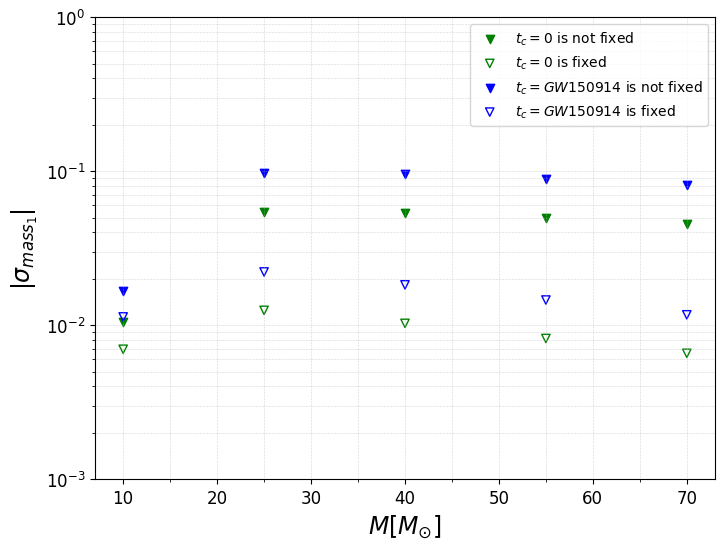

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, marker='v', color='g', label='$t_c=0$ is not fixed')
ax.scatter(x2, y2, marker='v', color='g', facecolors='none', label='$t_c=0$ is fixed')
ax.scatter(x3, y3, marker='v', color='b', label='$t_c=GW150914$ is not fixed')
ax.scatter(x4, y4, marker='v', color='b', facecolors='none', label='$t_c=GW150914$ is fixed')

ax.set_xlabel('$M [M_{\odot}]$', fontsize=17)
ax.set_ylabel(f'$|\u03C3_{{{parameter_of_interest}}}|$', fontsize=17)
ax.set_yscale('log')
ax.set_ylim(10**(-3), 10**0)
ax.legend(loc='upper right', fontsize=10, ncol=1, fancybox=True)
ax.grid(linestyle='dotted', linewidth='0.4', which='both')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)

plt.grid(True)
plt.show()